# EDA

Import một số thư viện cần thiết cho việc EDA dữ liệu:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import MinMaxScaler

import os
import re
from sklearn.base import clone
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
from scipy.optimize import minimize
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import polars as pl
import polars.selectors as cs
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
import seaborn as sns

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
import torch
import torch.nn as nn
import torch.optim as optim

from colorama import Fore, Style
from IPython.display import clear_output
import warnings
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

Một số function cần thiết cho việc EDA dữ liệu

In [2]:
def plot_related_cols(df, columns_list):
    # Thiết lập số cột và hàng
    n_cols = 4
    n_rows = -(-len(columns_list) // n_cols)  # Tính số hàng cần thiết (chia làm tròn lên)
    
    # Tạo figure lớn
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))  # Điều chỉnh kích thước phù hợp
    axes = axes.flatten()  # Chuyển ma trận axes thành 1D để dễ xử lý
    
    # Vẽ biểu đồ cho từng cột
    for i, col in enumerate(columns_list):
        value_counts = df[col].value_counts(sort=False).sort_index()  # Đếm tần suất
        
        value_counts.plot(kind='bar', ax=axes[i], title=col)  # Vẽ biểu đồ
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Số lượng')
    
    # Ẩn các ô không sử dụng nếu số cột không chia hết
    for i in range(len(columns_list), len(axes)):
        axes[i].axis('off')  # Tắt ô không dùng
    
    # Tinh chỉnh layout
    plt.tight_layout()
    plt.show()

def plot_kde(df, column_name):
    """
    Vẽ biểu đồ KDE cho một cột trong DataFrame.

    Parameters:
    - df: DataFrame chứa dữ liệu.
    - column_name: Tên cột mà bạn muốn vẽ KDE.

    Returns:
    - Không trả về giá trị, chỉ vẽ biểu đồ.
    """
    if column_name not in df.columns:
        print(f"Cột '{column_name}' không tồn tại trong DataFrame.")
        return

    # Vẽ KDE cho cột với tham số 'fill=True' thay cho 'shade=True'
    sns.kdeplot(df[column_name], fill=True)
    
    # Thêm tiêu đề và nhãn cho trục
    plt.title(f"Kernel Density Estimate (KDE) for {column_name}")
    plt.xlabel(column_name)
    plt.ylabel('Density')
    
    # Hiển thị biểu đồ
    plt.show()


def plot_kde_and_box(df, column_name):
    """
    Vẽ cả KDE plot và Box plot cho một cột trong DataFrame,
    đồng thời trả về các giá trị outliers trong Box plot.

    Parameters:
    - df: DataFrame chứa dữ liệu.
    - column_name: Tên cột mà bạn muốn vẽ biểu đồ.

    Returns:
    - outliers: Danh sách các giá trị outliers trong cột.
    """
    # Kiểm tra nếu cột tồn tại trong DataFrame
    if column_name not in df.columns:
        print(f"Cột '{column_name}' không tồn tại trong DataFrame.")
        return
    dataframe = df[column_name]
    
    # Tính toán Q1, Q3, IQR để xác định các outliers
    Q1 = dataframe.quantile(0.25)
    Q3 = dataframe.quantile(0.75)
    IQR = Q3 - Q1

    # Xác định các outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Lọc các giá trị outliers
    outliers = dataframe[dataframe < lower_bound].tolist() + dataframe[dataframe > upper_bound].tolist()
    

    # Vẽ KDE và Boxplot
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Vẽ KDE trên axes[0]
    sns.kdeplot(dataframe, fill=True, ax=axes[0])
    axes[0].set_title(f"KDE Plot for {column_name}")
    axes[0].set_xlabel(column_name)
    axes[0].set_ylabel('Density')

    # Vẽ Boxplot trên axes[1]
    sns.boxplot(x=dataframe, ax=axes[1])
    axes[1].set_title(f"Boxplot for {column_name}")
    axes[1].set_xlabel(column_name)

    # Hiển thị biểu đồ
    plt.tight_layout()
    plt.show()

    # Trả về các giá trị outliers
    return outliers

def replace_outliers(df, column_name, outliers, replacement_value=None):
    """
    Thay thế các giá trị outliers trong một cột của DataFrame bằng giá trị thay thế.
    
    Parameters:
    - df: DataFrame chứa dữ liệu.
    - column_name: Tên cột cần xử lý outliers.
    - outliers: Danh sách các giá trị outliers.
    - replacement_value: Giá trị thay thế. Mặc định là None (thay bằng trung vị của cột).
    
    Returns:
    - df: DataFrame sau khi đã thay thế outliers.
    """
    # Nếu không có giá trị thay thế, sử dụng trung vị của cột
    if replacement_value is None:
        replacement_value = np.nan #df[column_name].median()
    
    # Thay thế các giá trị outliers
    df[column_name] = df[column_name].apply(lambda x: replacement_value if x in outliers else x)
    
    return df

def remove_outlier(df, columns):
    for column in columns:
        # # Step 0: Create a boxplot
        # plt.figure(figsize=(8, 6))
        # sns.boxplot(x=df[column])
        # plt.title('Boxplot for column_name (Outliers replaced with NaN)')
        # plt.show()

        # Step 1: Identify the outliers
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define the outlier thresholds
        lower_bound = Q1 - 5 * IQR
        upper_bound = Q3 + 5 * IQR
        
        # Step 2: Replace outliers with NaN
        df[column] = df[column].apply(lambda x: np.nan if x < lower_bound or x > upper_bound else x)
        
    return df

# Tính phần trăm missing data
def missing_percentage(df, column_name):
    total_values = len(df[column_name])
    missing_values = df[column_name].isna().sum()
    percentage_missing = (missing_values / total_values) * 100
    return percentage_missing

# read file parquet
def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return df.describe().values.reshape(-1), filename.split('=')[1]

# load time series from parquet files
def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    stats, indexes = zip(*results)
    
    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    return df

Load các file dữ liệu

In [3]:
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
data_dict = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/data_dictionary.csv')
sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')
train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")

100%|██████████| 2/2 [00:00<00:00, 10.49it/s]


### Quan sát các nhóm feature được chia theo như mô tả của dataset

In [4]:
data_dict.head()

,Instrument,Field,Description,Type,Values,Value Labels
0,Identifier,id,Participant's ID,str,NaN,NaN
1,Demographics,Basic_Demos-Enroll_Season,Season of enrollment,str,"Spring, Summer, Fall, Winter",NaN
2,Demographics,Basic_Demos-Age,Age of participant,float,NaN,NaN
3,Demographics,Basic_Demos-Sex,Sex of participant,categorical int,"0,1","0=Male, 1=Female"
4,Children's Global Assessment Scale,CGAS-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN


In [5]:
groups = data_dict.groupby('Instrument')['Field'].apply(list).to_dict()

for instrument, features in groups.items():
    print(f"{instrument}: {features}\n")

Bio-electric Impedance Analysis: ['BIA-Season', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW']

Children's Global Assessment Scale: ['CGAS-Season', 'CGAS-CGAS_Score']

Demographics: ['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex']

FitnessGram Child: ['FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone']

FitnessGram Vitals and Treadmill: ['Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec']

Identifier: ['id']

Internet Use: ['PreInt_EduHx-Season', 'PreInt_EduHx-computerinternet_hoursday']

P

## PCIAT (22 cols):
- Link câu hỏi: https://www.healthyplace.com/psychological-tests/parent-child-internet-addiction-test
- Dựa vào kết quả của 20 câu hỏi trong bài test này, lấy tổng rồi phân đoạn là ra được sii
-> Tức là sii trong train data được suy ra từ kết quả bài test PCIAT.
- Những row không có kết quả PCIAT thì cũng không có sii.

In [6]:
PCIAT_cols = data_dict[data_dict['Instrument'] == 'Parent-Child Internet Addiction Test']['Field']
for col in PCIAT_cols:
    print(f" Missing percent of {col}: {missing_percentage(df=train, column_name=col)}")
print(f" Missing percent of sii: {missing_percentage(df=train, column_name='sii')}")

 Missing percent of PCIAT-Season: 30.909090909090907
 Missing percent of PCIAT-PCIAT_01: 30.984848484848488
 Missing percent of PCIAT-PCIAT_02: 30.95959595959596
 Missing percent of PCIAT-PCIAT_03: 31.035353535353533
 Missing percent of PCIAT-PCIAT_04: 31.035353535353533
 Missing percent of PCIAT-PCIAT_05: 31.085858585858585
 Missing percent of PCIAT-PCIAT_06: 31.01010101010101
 Missing percent of PCIAT-PCIAT_07: 31.085858585858585
 Missing percent of PCIAT-PCIAT_08: 31.060606060606062
 Missing percent of PCIAT-PCIAT_09: 31.060606060606062
 Missing percent of PCIAT-PCIAT_10: 30.984848484848488
 Missing percent of PCIAT-PCIAT_11: 30.95959595959596
 Missing percent of PCIAT-PCIAT_12: 31.035353535353533
 Missing percent of PCIAT-PCIAT_13: 31.085858585858585
 Missing percent of PCIAT-PCIAT_14: 31.01010101010101
 Missing percent of PCIAT-PCIAT_15: 31.060606060606062
 Missing percent of PCIAT-PCIAT_16: 31.11111111111111
 Missing percent of PCIAT-PCIAT_17: 31.186868686868685
 Missing percent 

Có thể thấy rằng các cột trong PCIAT có tỉ lệ missing không giống nhau, tuy nhiên 'PCIAT-PCIAT_Total' và 'sii' sẽ luôn đi cùng nhau. Giá trị của ‘PCIAT-PCIAT_Total’ high correlation với ‘sii’ và có thể dùng để trực tiếp dự đoán ra giá trị ‘sii’ như sau: 
- Tổng điểm từ 0 - 30: sii có nhãn là 0
- Tổng điểm từ 31 - 49: sii có nhãn là 1
- Tổng điểm từ 50- 79: sii có nhãn là 2
- Tổng điểm từ 80 - 100: sii có nhãn là 3

Những cột có 'PCIAT-PCIAT_Total' mà những cột khác bị NaN thì giá trị của 'PCIAT-PCIAT_Total được tính bằng tổng giá trị của những cột không NaN, nên có thể điền 0 vào 'PCIAT-PCIAT_{i}' với i từ 01 đến 20.

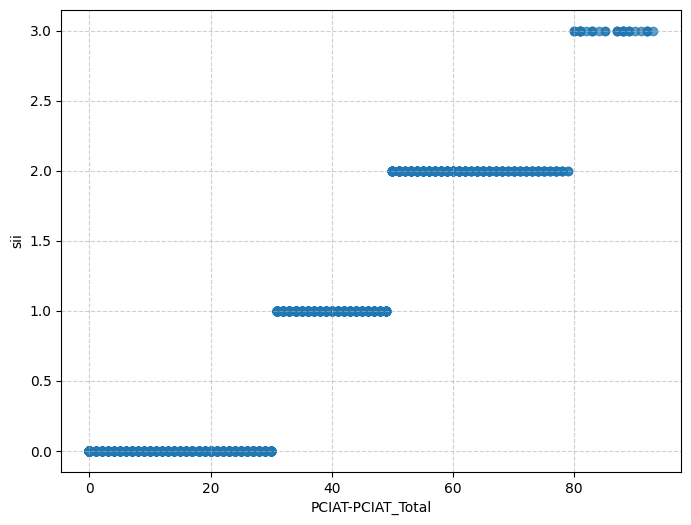

In [7]:
plt.figure(figsize=(8, 6))
plt.scatter(train['PCIAT-PCIAT_Total'], train['sii'], alpha=0.7)
plt.title('')
plt.ylabel('sii')
plt.xlabel('PCIAT-PCIAT_Total')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Cột 'sii' là nhãn nên không nên điền vào cột này, trong cuộc thi cũng có nói rằng những dòng bị miss 'sii' dùng cho các phương pháp unsupervised learning.

## Bio-electric Impedance Analysis (17 cols): 
Đo lường các yếu tố chính cấu thành cơ thể, bao gồm BMI, chất béo, cơ và hàm lượng nước.
- 'BIA-Season': Mùa tham gia
- 'BIA-BIA_Activity_Level_num': Mức hoạt động: Rất nhẹ -> Rất nặng.
- 'BIA-BIA_BMC': Hàm lượng khoáng chất trong xương.
- 'BIA-BIA_BMI': Đo chỉ số 'béo phì' :v.
- 'BIA-BIA_BMR': Tỷ lệ trao đổi chất cơ bản.
- 'BIA-BIA_DEE': Tiêu thụ năng lượng hàng ngày.
- 'BIA-BIA_Frame_num': Khung người: nhỏ, vừa, to.
- - 'BIA-BIA_FFM': Khối lượng nạc và khối lượng cơ xương (khối lượng không tính chất béo).
  - 'BIA-BIA_FMI': Khối lượng chất béo.
  - 'BIA-BIA_FFMI': Là cái trên nhưng thêm index :v.
  - 'BIA-BIA_Fat': Tỷ lệ mỡ cơ thể.
  - 'BIA-BIA_LST': Mô mềm nạc.
  - 'BIA-BIA_LDM': Khối lượng nạc khô.
  - 'BIA-BIA_SMM': Khối lượng cơ xương.
- 'BIA-BIA_TBW': Tổng lượng nước cơ thể.
- - 'BIA-BIA_ECW': Lượng nước nằm bên ngoài các tế bào.
  - 'BIA-BIA_ICW': Lượng nước trong tế bào.

In [8]:
BIA_cols = data_dict[data_dict['Instrument'] == 'Bio-electric Impedance Analysis']['Field']
for col in BIA_cols:
    print(f" Missing percent of {col}: {missing_percentage(df=train, column_name=col)}")

 Missing percent of BIA-Season: 45.83333333333333
 Missing percent of BIA-BIA_Activity_Level_num: 49.72222222222222
 Missing percent of BIA-BIA_BMC: 49.72222222222222
 Missing percent of BIA-BIA_BMI: 49.72222222222222
 Missing percent of BIA-BIA_BMR: 49.72222222222222
 Missing percent of BIA-BIA_DEE: 49.72222222222222
 Missing percent of BIA-BIA_ECW: 49.72222222222222
 Missing percent of BIA-BIA_FFM: 49.72222222222222
 Missing percent of BIA-BIA_FFMI: 49.72222222222222
 Missing percent of BIA-BIA_FMI: 49.72222222222222
 Missing percent of BIA-BIA_Fat: 49.72222222222222
 Missing percent of BIA-BIA_Frame_num: 49.72222222222222
 Missing percent of BIA-BIA_ICW: 49.72222222222222
 Missing percent of BIA-BIA_LDM: 49.72222222222222
 Missing percent of BIA-BIA_LST: 49.72222222222222
 Missing percent of BIA-BIA_SMM: 49.72222222222222
 Missing percent of BIA-BIA_TBW: 49.72222222222222


In [9]:
train[BIA_cols].describe()

,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW
count,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.00000,1991.000000,1991.000000,1991.000000
mean,2.651431,6.719826,19.367048,1237.018187,2064.693747,20.825346,74.021708,15.030554,4.336495,16.855020,1.745354,33.173380,20.02299,67.301883,34.389466,53.998726
std,1.028267,92.586325,5.047848,1872.383246,2836.246272,73.266287,199.433753,5.792505,6.356402,199.372119,0.680635,56.272346,70.21561,108.705918,84.050607,129.362539
min,1.000000,-7.789610,0.048267,813.397000,1073.450000,1.789450,28.900400,7.864850,-194.163000,-8745.080000,1.000000,14.489000,4.63581,23.620100,4.655730,20.589200
25%,2.000000,2.966905,15.913600,1004.710000,1605.785000,11.109550,49.278100,13.408000,2.306915,8.602395,1.000000,24.463500,12.98315,45.204100,21.141550,35.887000
50%,3.000000,3.922720,17.966500,1115.380000,1863.980000,15.928000,61.066200,14.092500,3.698630,16.174600,2.000000,28.855800,16.43880,56.996400,27.415100,44.987000
75%,3.000000,5.460925,21.461100,1310.360000,2218.145000,25.162200,81.833800,15.430950,5.987690,30.273100,2.000000,35.475700,22.16760,77.105650,38.179400,60.271050
max,5.000000,4115.360000,53.924300,83152.200000,124728.000000,3233.000000,8799.080000,217.771000,28.251500,153.820000,3.000000,2457.910000,3108.17000,4683.710000,3607.690000,5690.910000


Có thể thấy rằng một số giá trị min và max có vẻ không hợp lý. Điều này được chứng minh tại các mốc 25%, 50%, 75%, giá trị không thay đổi quá nhiều nhưng giá trị min và max lại cách rất xa các giá trị này.

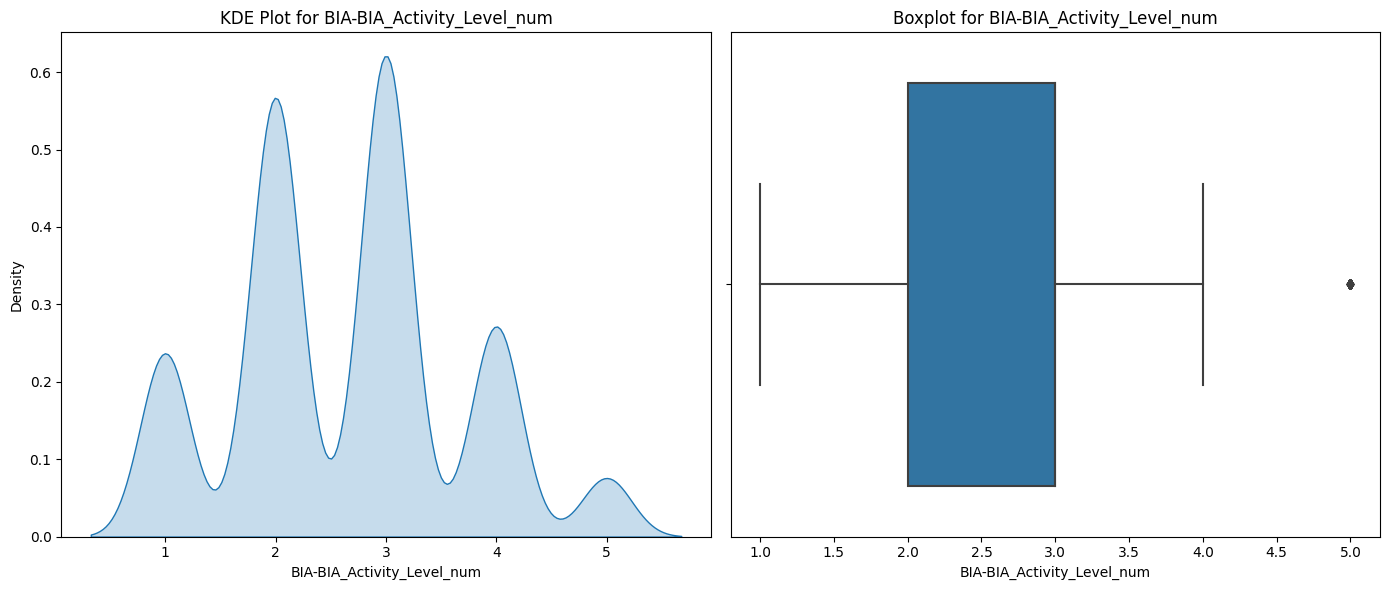

85


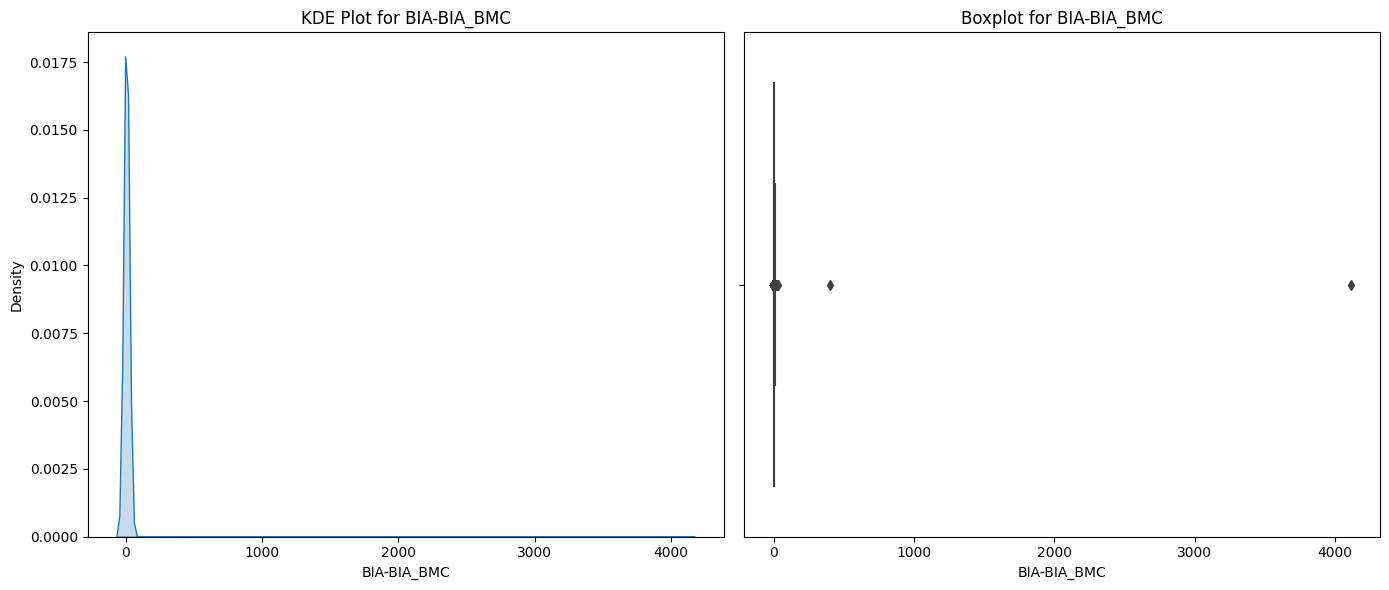

111


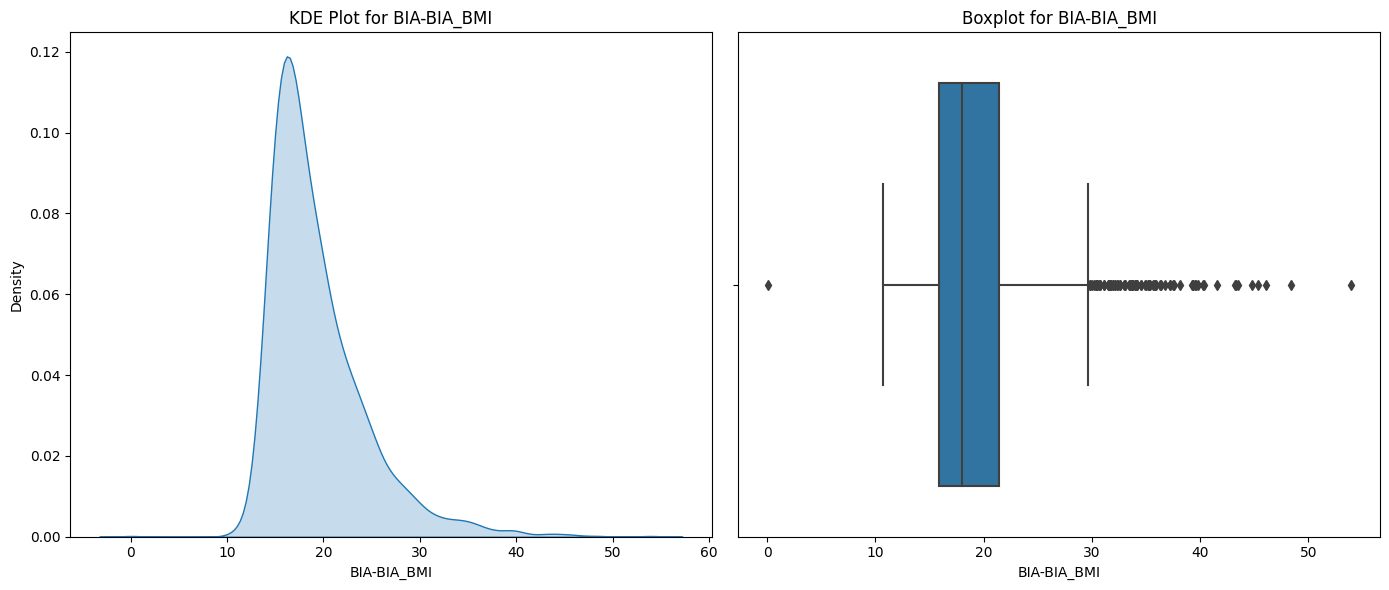

86


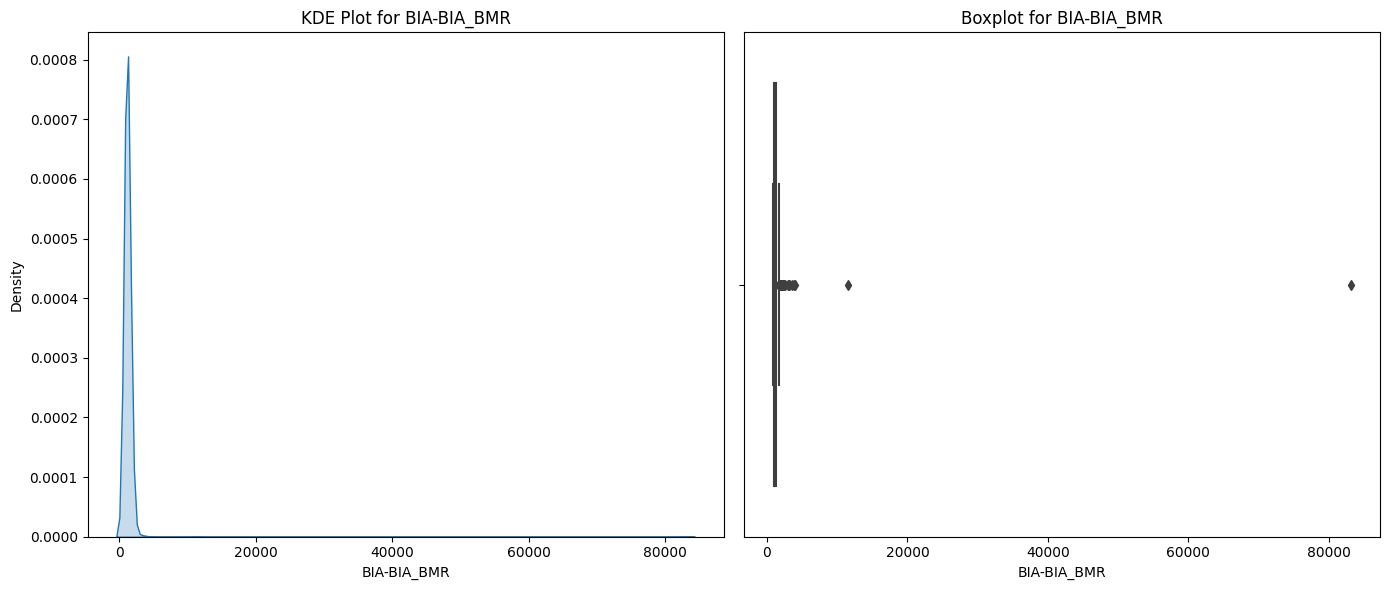

63


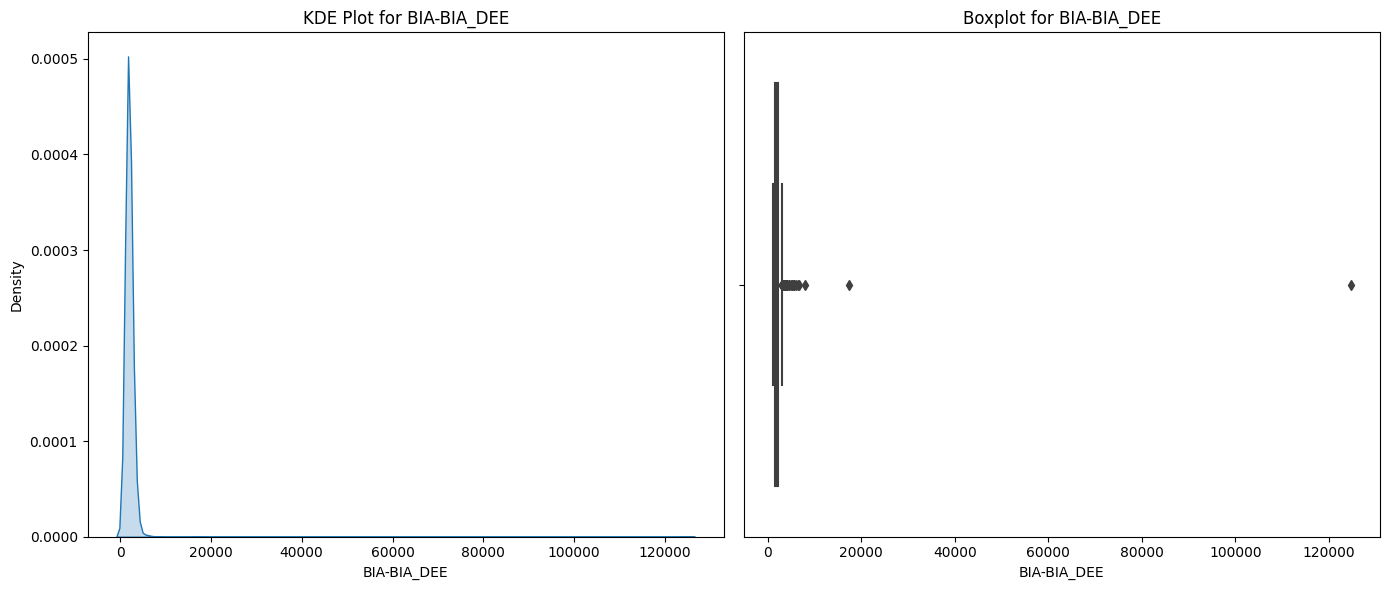

94


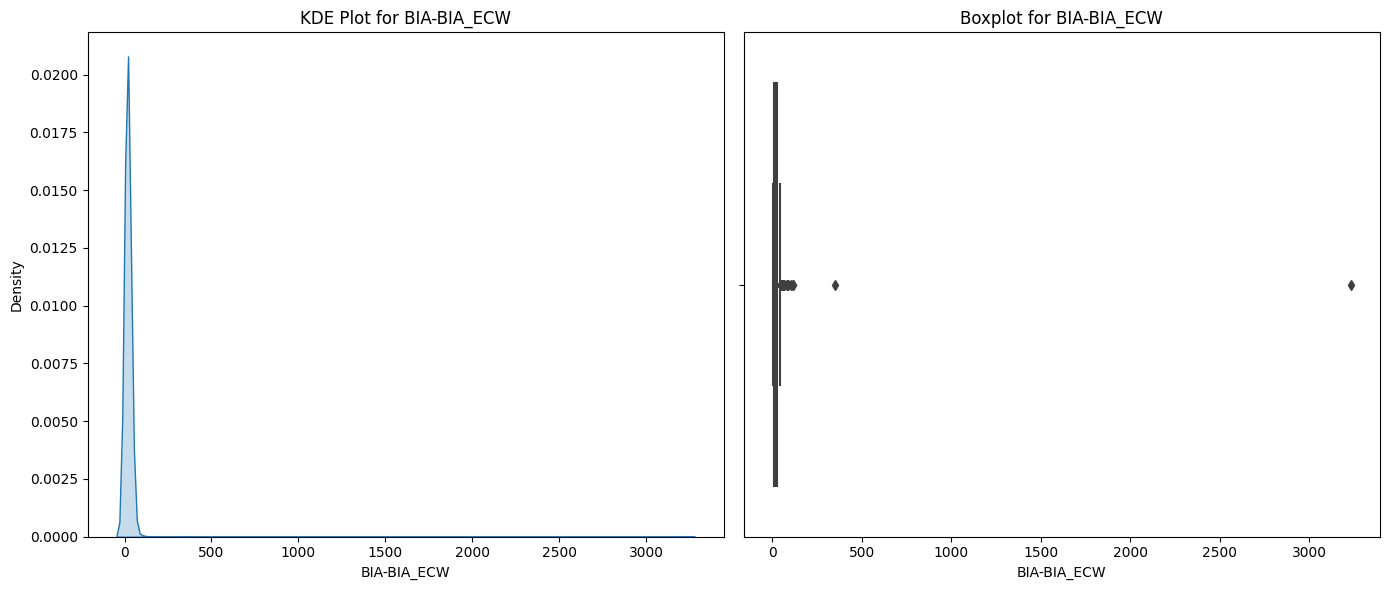

43


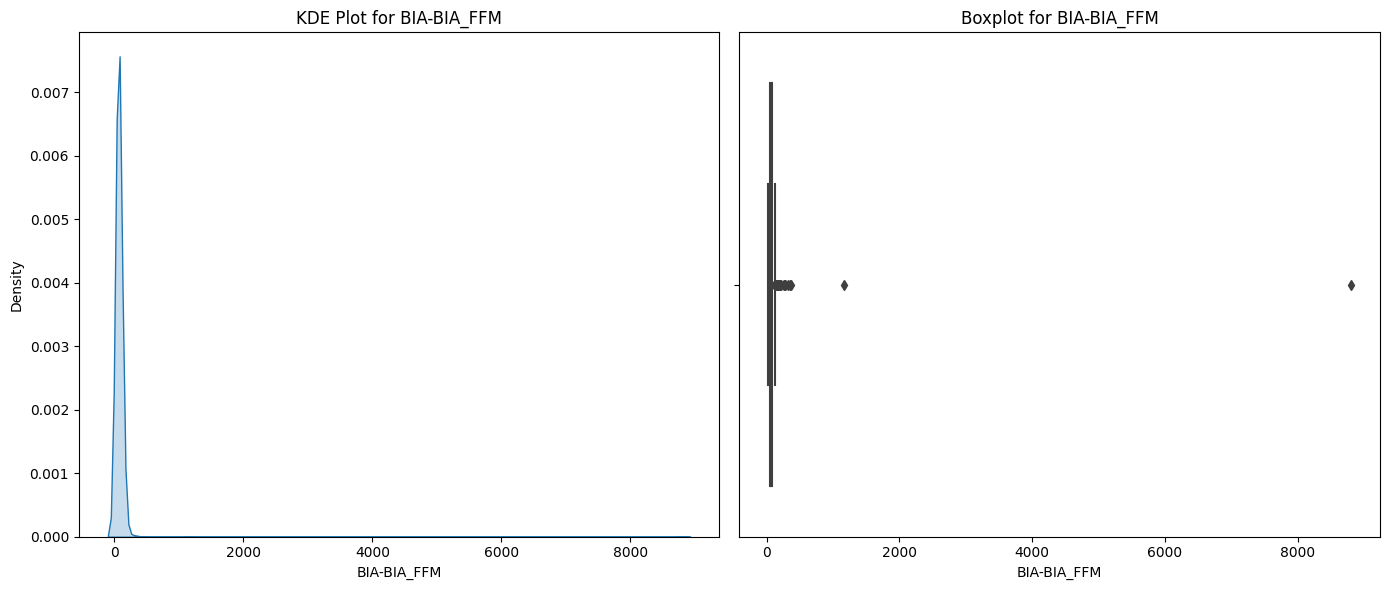

63


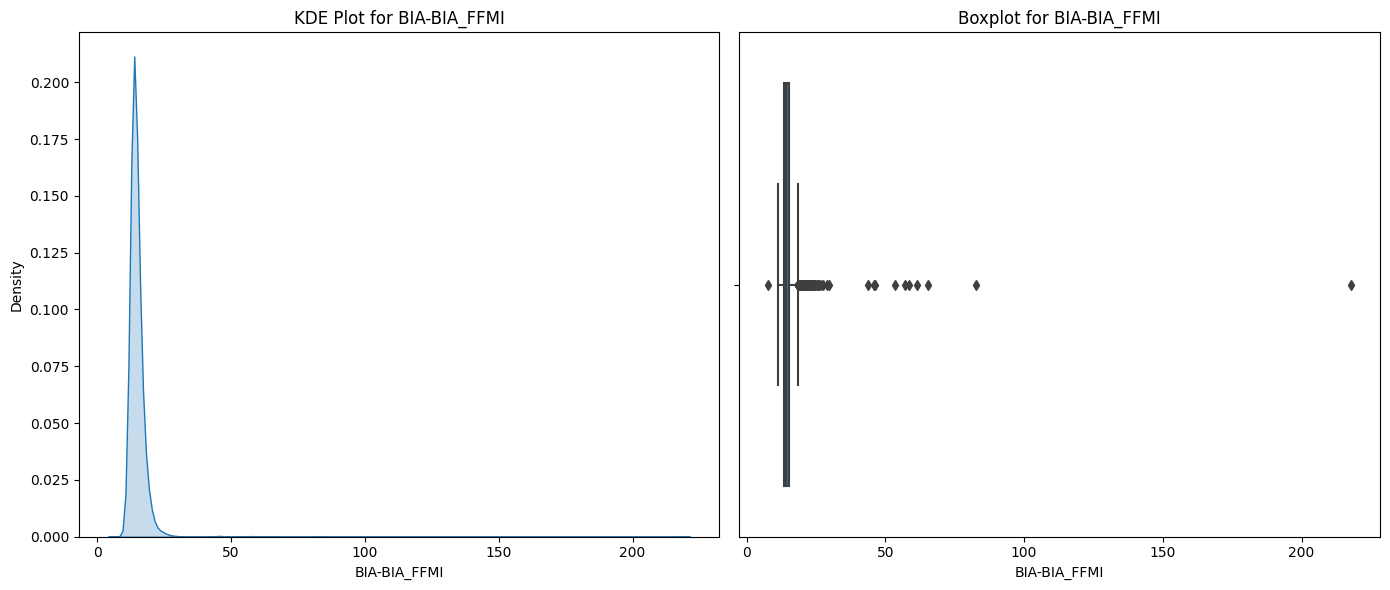

122


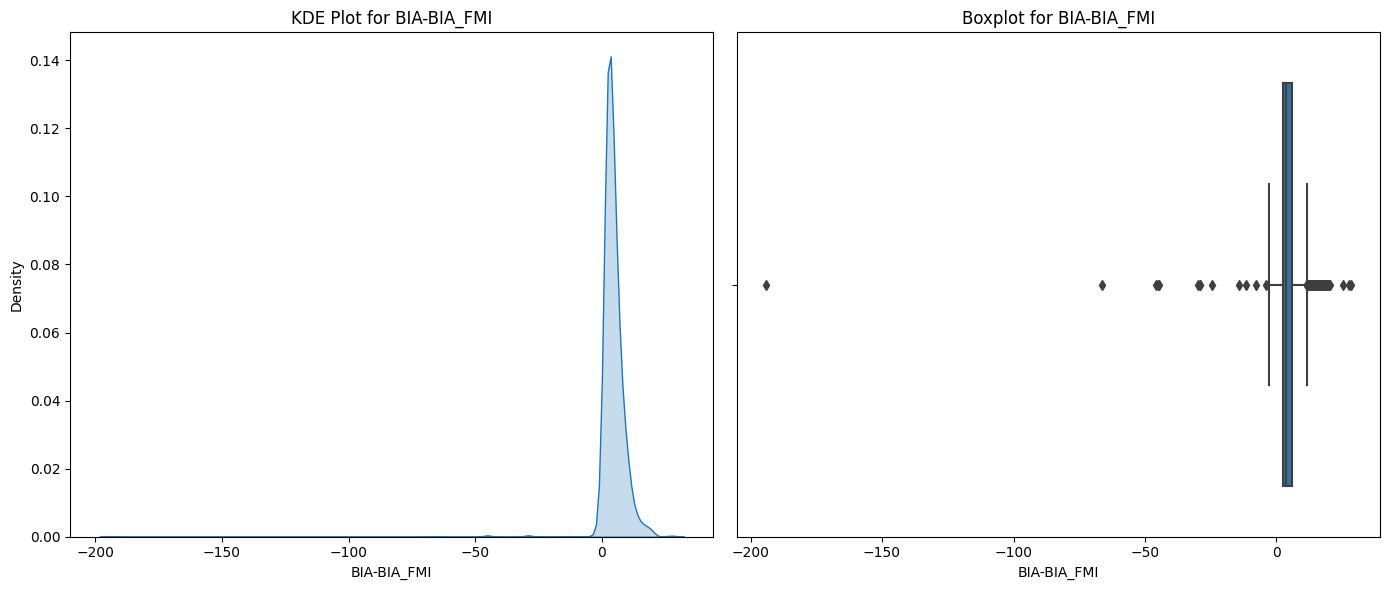

104


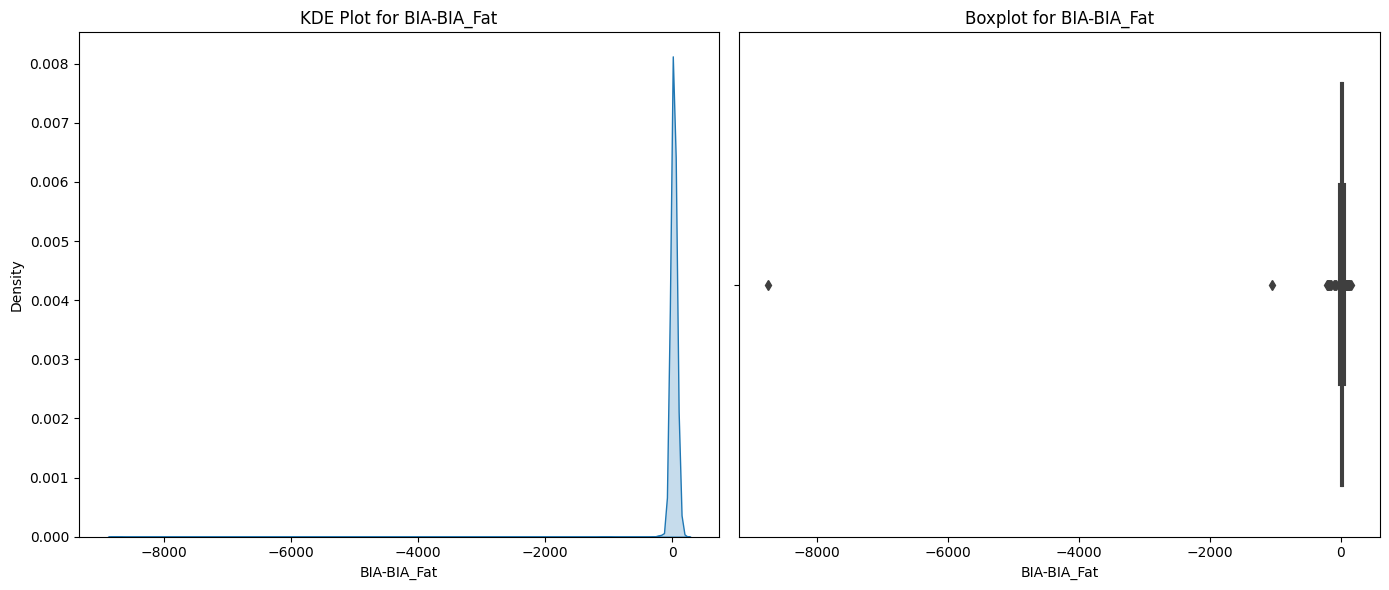

118


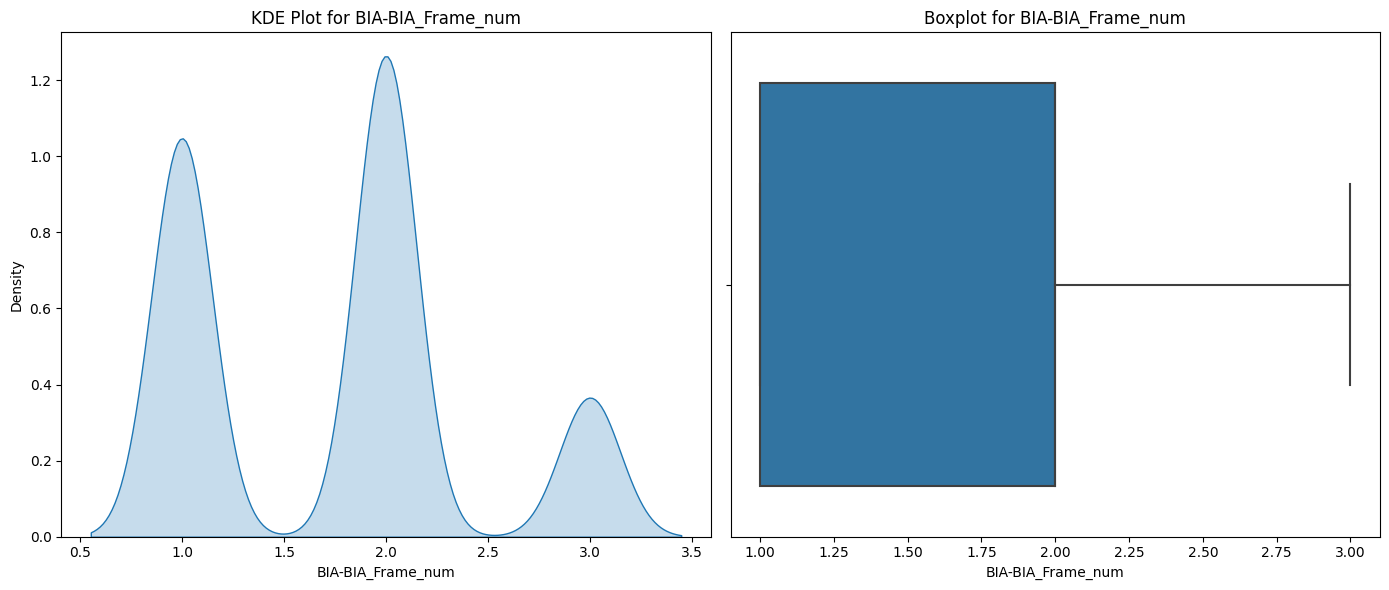

0


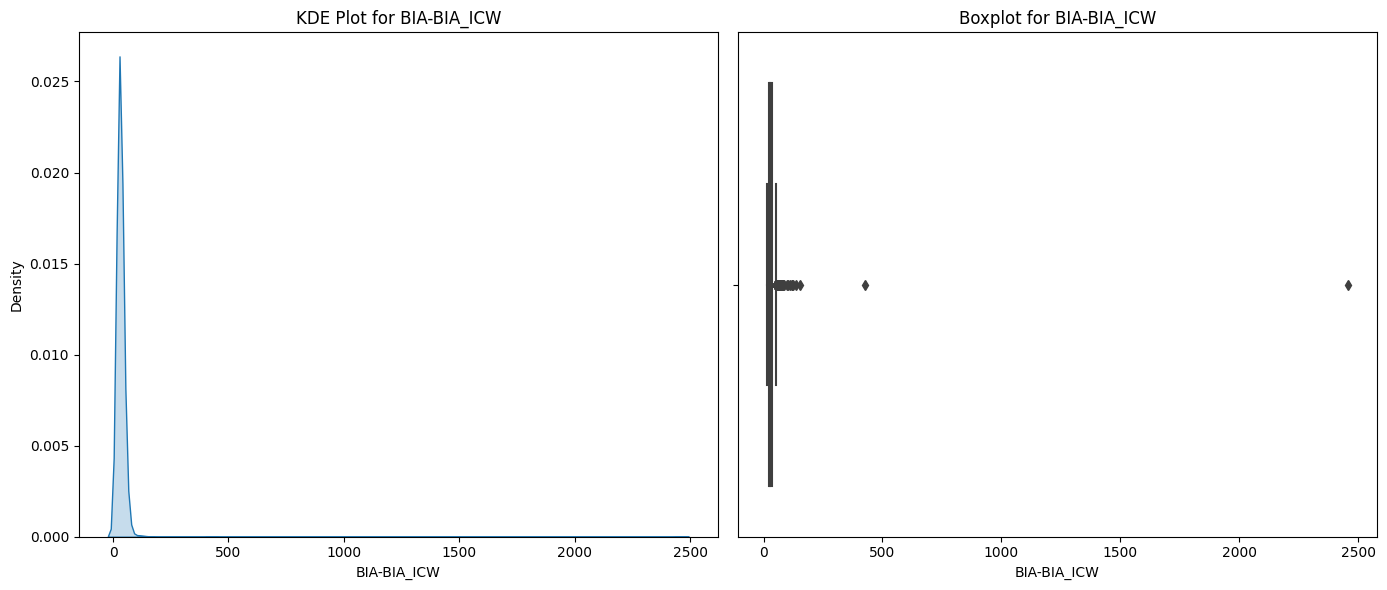

108


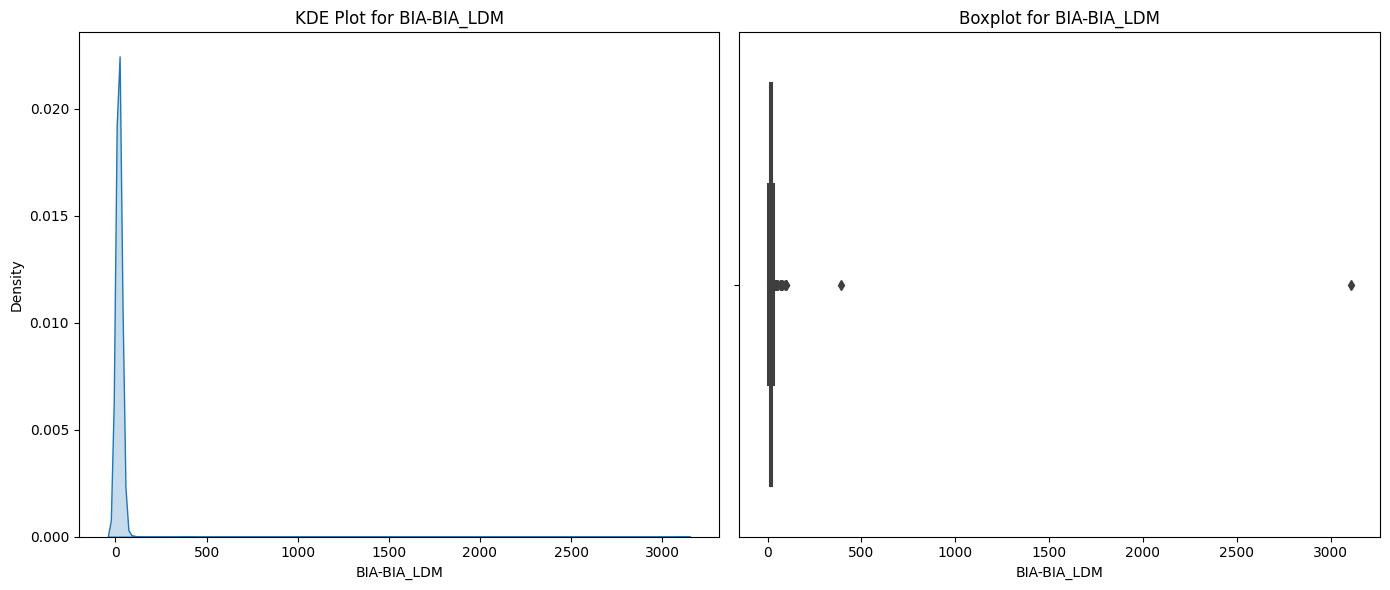

45


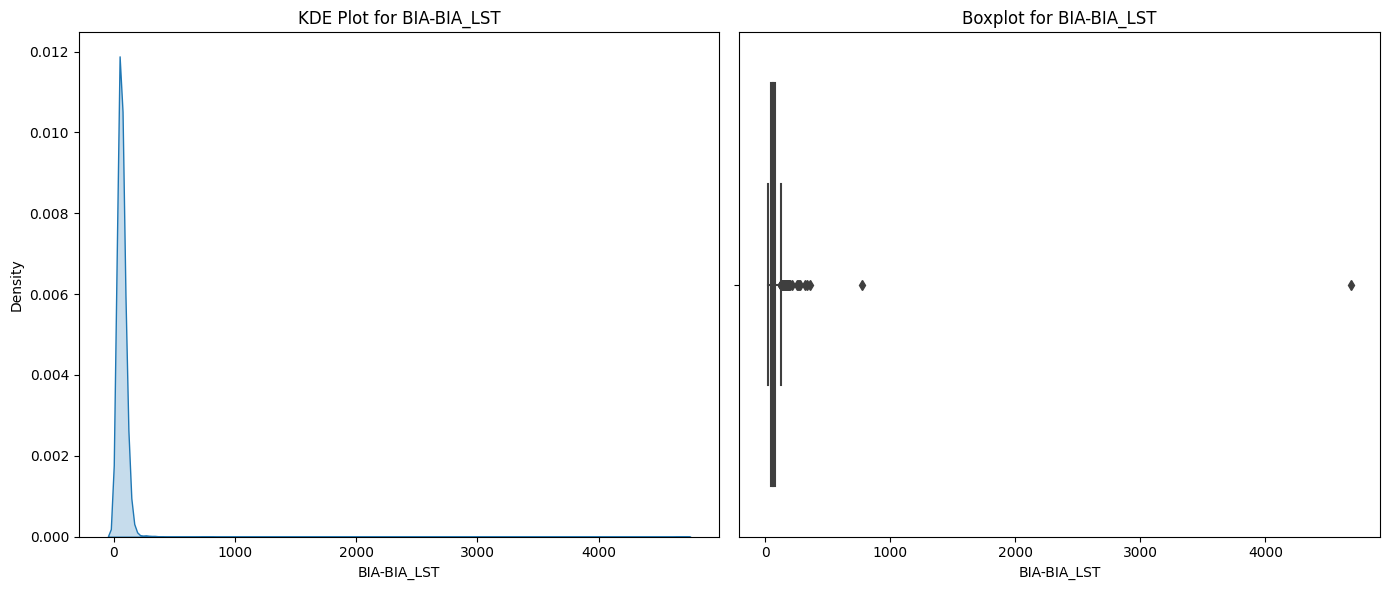

62


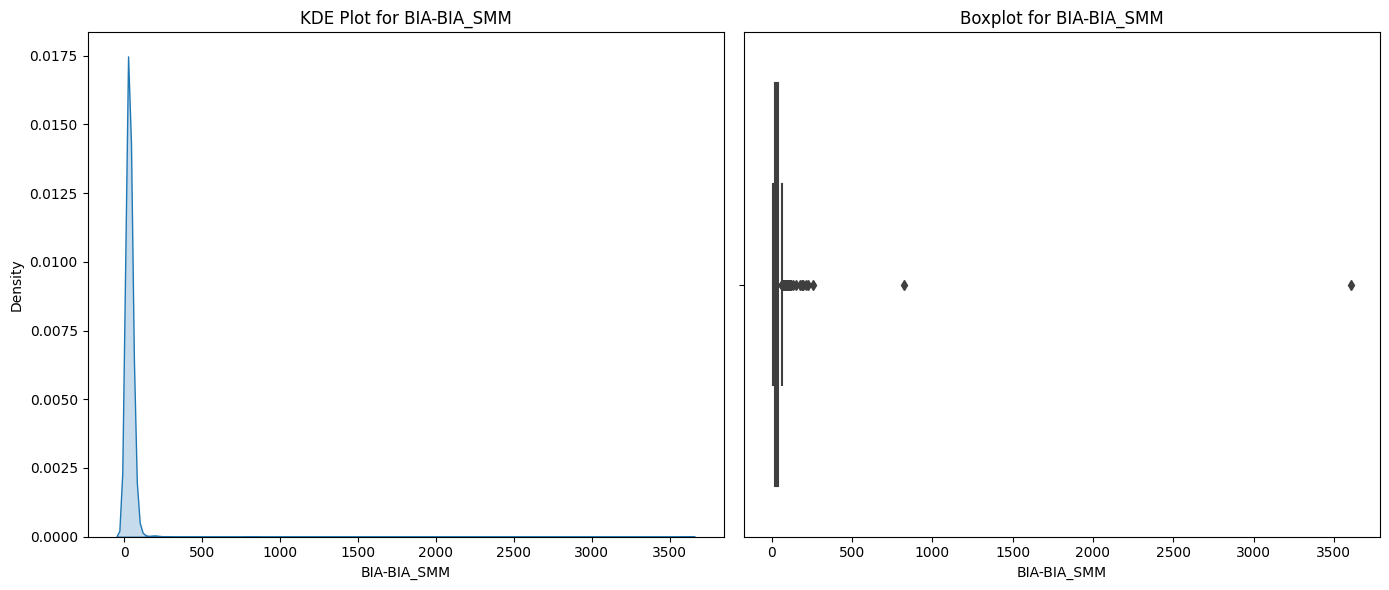

76


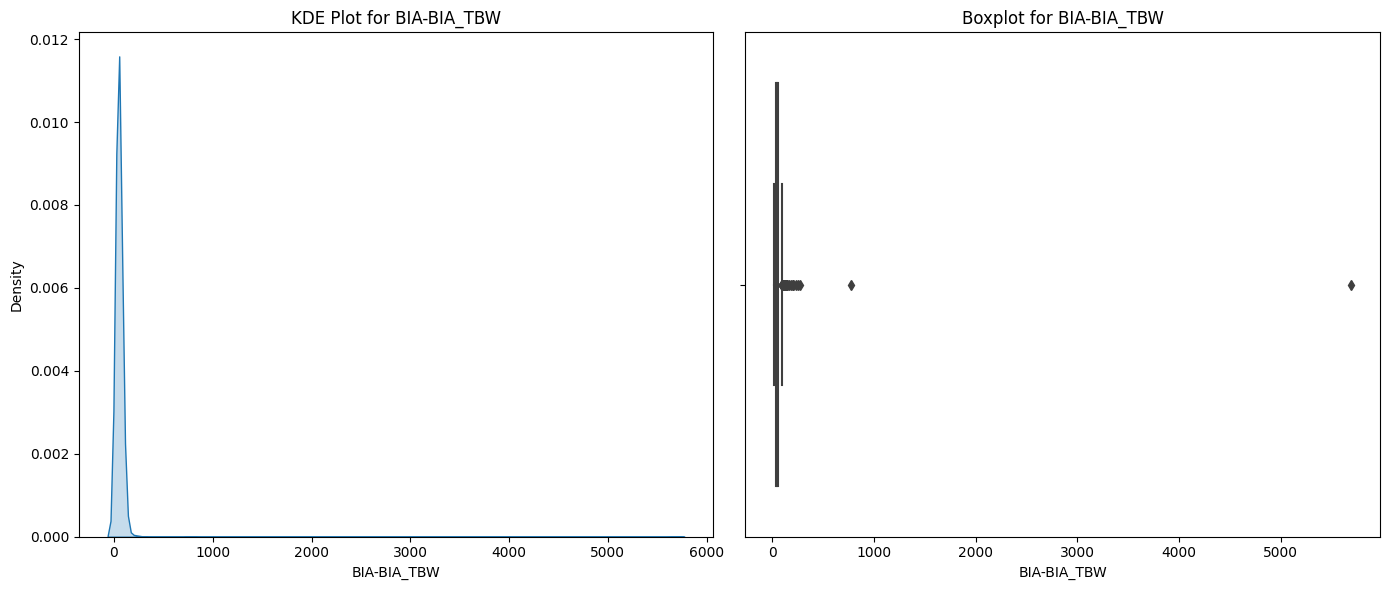

63


In [10]:
for col in BIA_cols:
    if 'Season' not in col:
        outlier = plot_kde_and_box(train, col)
        # print(outlier)
        print(len(outlier))
        replace_value = train[col].median()

        train = replace_outliers(train, col, outlier, replace_value)

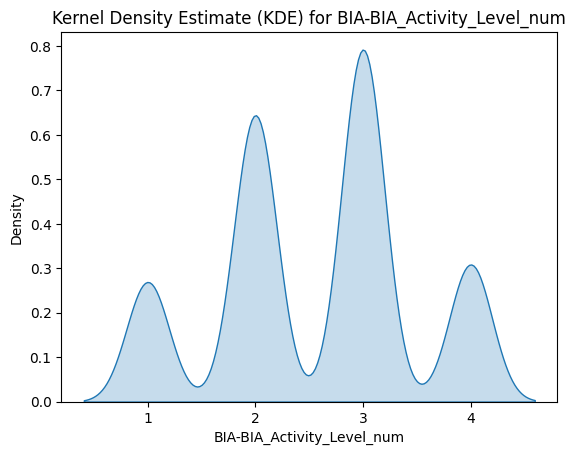

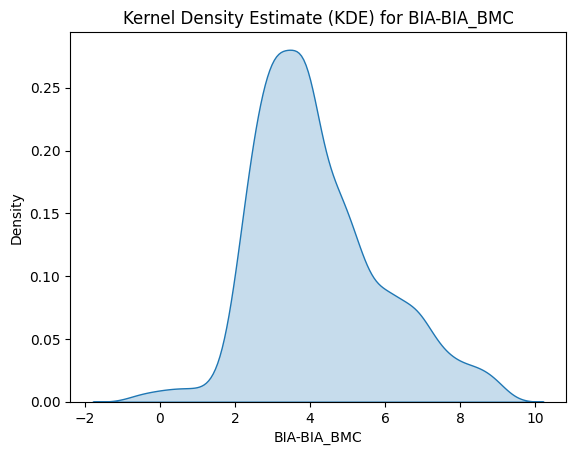

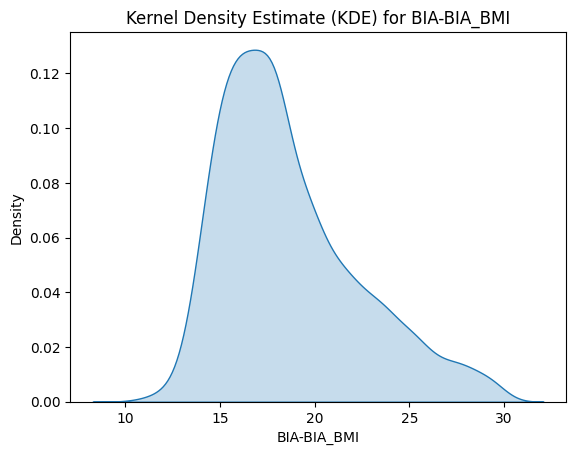

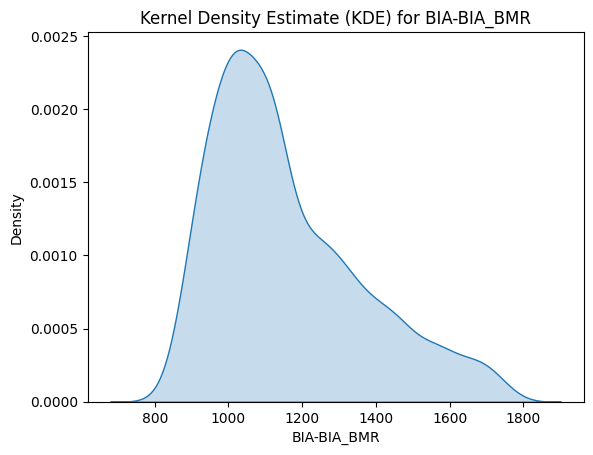

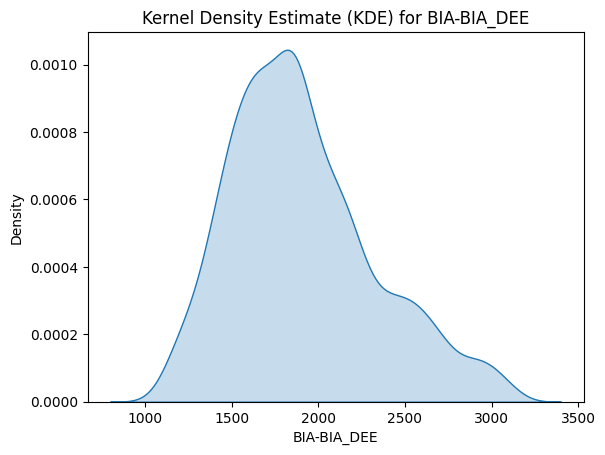

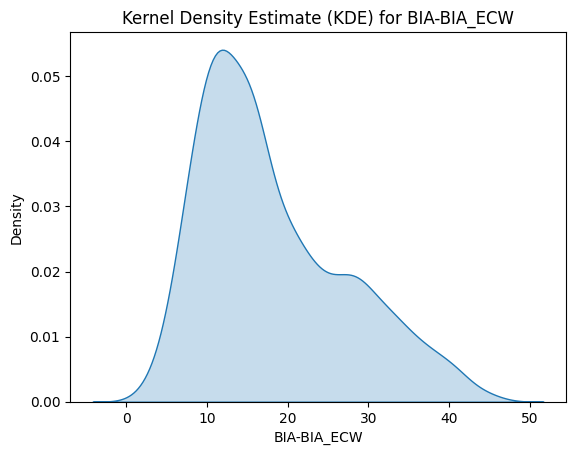

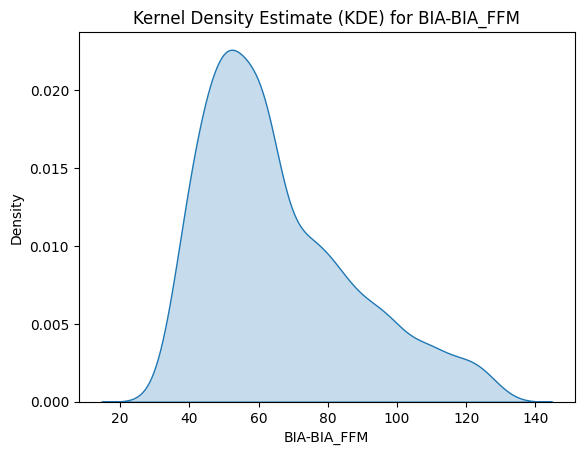

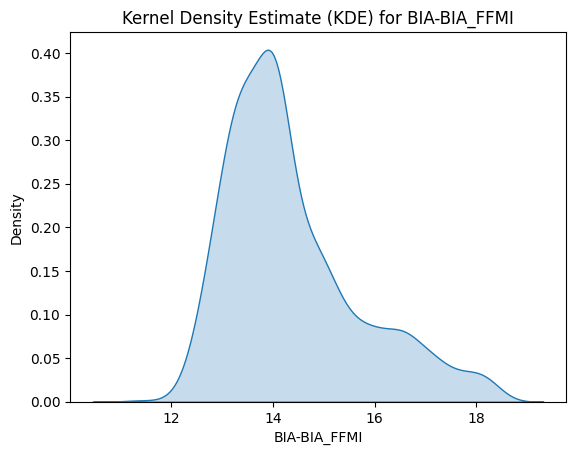

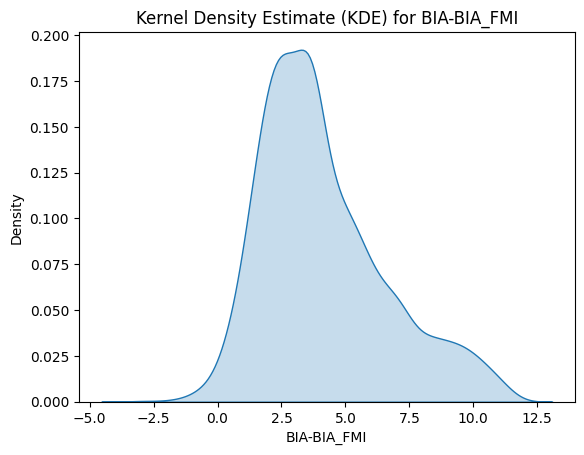

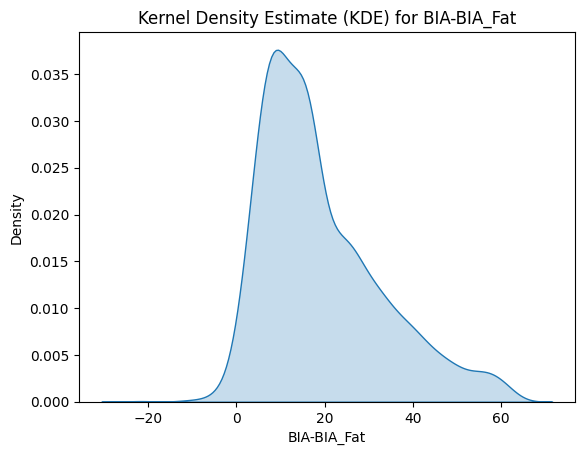

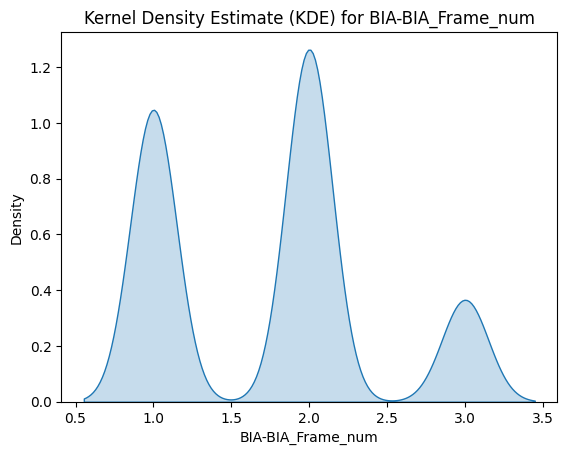

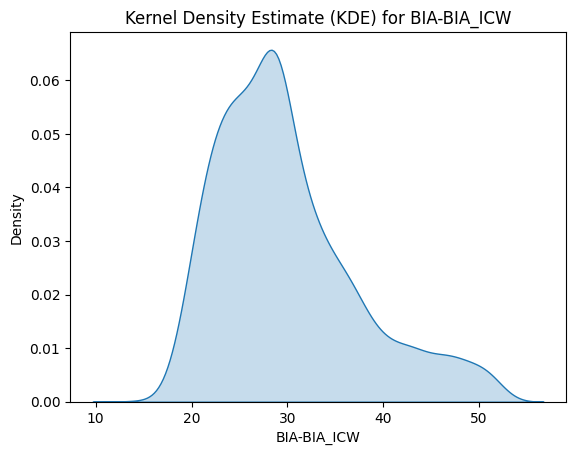

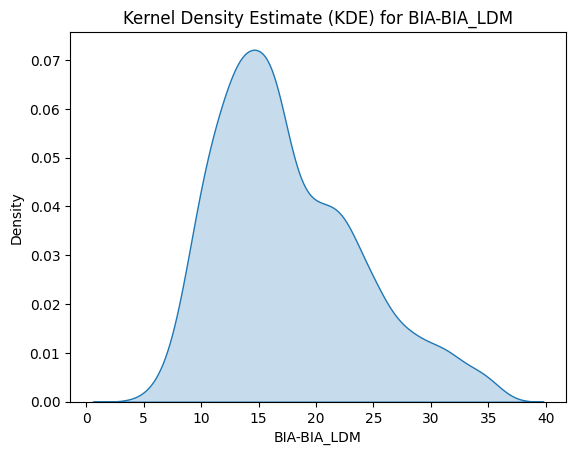

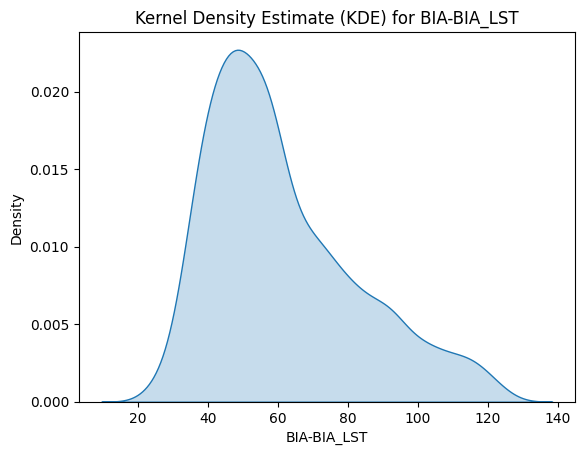

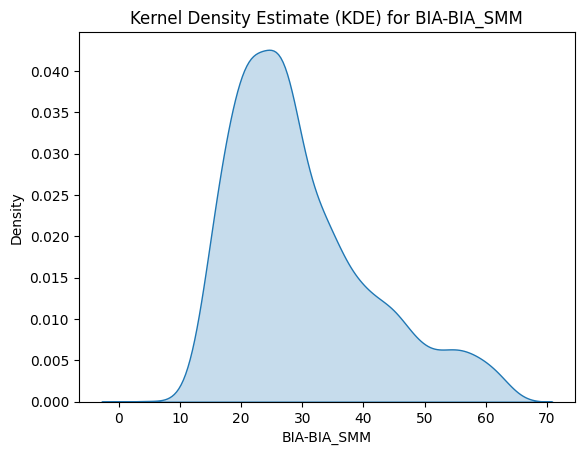

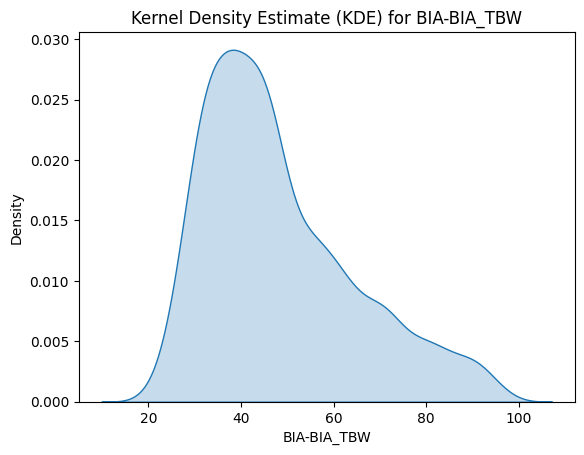

In [11]:
for col in BIA_cols:
    if 'Season' not in col:
        plot_kde(train, col)

In [12]:
for i in range(1,17):
    print(len(train[train[BIA_cols].isnull().sum(axis=1) >= i][BIA_cols]), end=', ')

1969, 1969, 1969, 1969, 1969, 1969, 1969, 1969, 1969, 1969, 1969, 1969, 1969, 1969, 1969, 1969, 

Từ số liệu trên và tỉ lệ missing, có thể thấy rằng dữ liệu của họ BIA nếu NaN sẽ NaN đồng loạt cả một dòng. Tuy nhiên, mỗi người tham gia không bị NaN thì đều có 1 giá trị riêng. Và có 1 feature đặc biệt là 'BIA-BIA_BMI' mang ý nghĩa giống với 'Physical-BMI'.

## Children's Global Assessment Scale (2 cols):
CGAS là thang đánh giá chức năng chung cho trẻ em và thanh thiếu niên. CGAS yêu cầu bác sĩ lâm sàng đánh giá trẻ từ 1 đến 100 dựa trên mức chức năng thấp nhất của trẻ, bất kể phương pháp điều trị hay tiên lượng, trong một khoảng thời gian cụ thể.

- 'CGAS-Season': Mùa đo.
- 'CGAS-CGAS_Score': Đánh giá của bác sĩ
- - 1-10 : Cần giám sát liên tục (chăm sóc 24 giờ)
  - 11-20 : Cần sự giám sát đáng kể
  - 21-30 : Không thể hoạt động ở hầu hết mọi lĩnh vực
  - 31-40 : Suy giảm nghiêm trọng chức năng ở một số 'area'
  - 41-50 : Mức độ can thiệp vừa phải vào chức năng
  - 51-60 : Chức năng thay đổi với khó khăn không thường xuyên
  - 61-70 : Một số khó khăn trong một 'area' duy nhất
  - 71-80 : Không hơn một sự suy giảm nhẹ trong hoạt động
  - 81-90 : Chức năng tốt trong tất cả 'area'
  - 91-100 : Hoạt động vượt trội

In [13]:
CGAS_cols = data_dict[data_dict['Instrument'] == "Children's Global Assessment Scale"]['Field']
for col in CGAS_cols:
    print(f" Missing percent of {col}: {missing_percentage(df=train, column_name=col)}")

 Missing percent of CGAS-Season: 35.47979797979798
 Missing percent of CGAS-CGAS_Score: 38.86363636363636


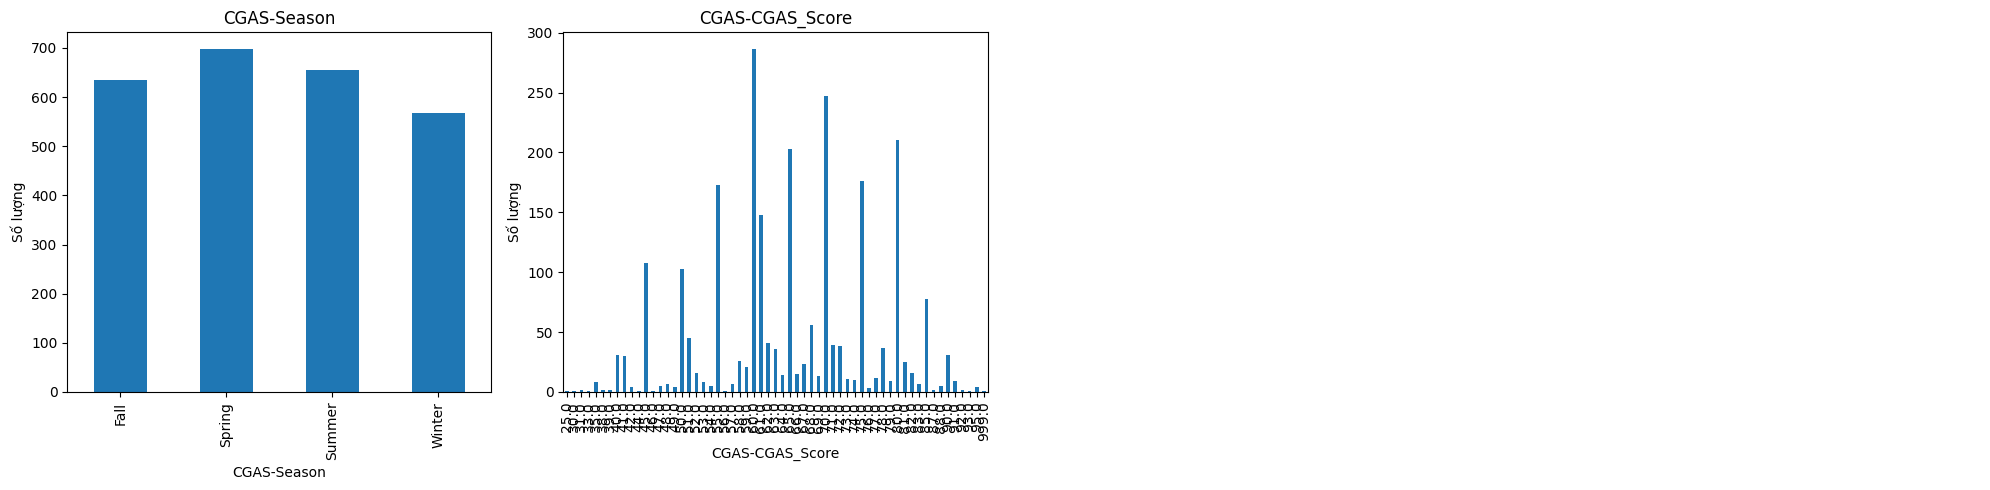

In [14]:
plot_related_cols(train, CGAS_cols)

Dữ liệu về mùa khá là cân bằng. Tuy nhiên, dữ liệu ở 'CGAS-CGAS_Score' khá là khó nhìn và id=83525bbe thì có score=999. Có thể data point này bị sai và có thể coi là outlier.

In [15]:
train.loc[train['id'] == '83525bbe', 'CGAS-CGAS_Score'] = np.nan
train[train['id'] == '83525bbe']

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
2065,83525bbe,Fall,11,1,Winter,NaN,Fall,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,NaN,NaN,NaN,Fall,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,2.241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,3.0,NaN


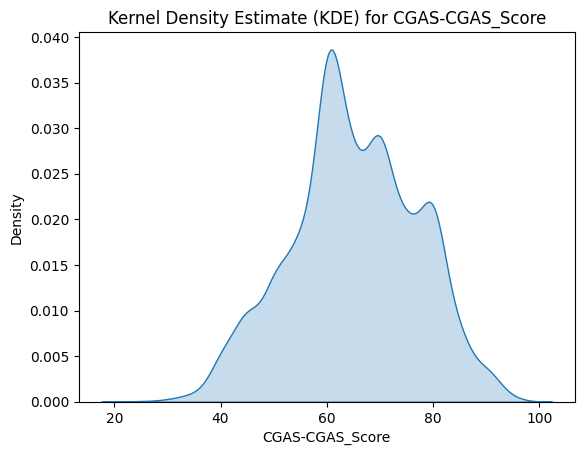

In [16]:
plot_kde(train, 'CGAS-CGAS_Score')

In [17]:
len(train[train['CGAS-CGAS_Score'].isna() ^ train['sii'].isna()])

472

Có thể thấy dữ liệu ở 'CGAS-CGAS_Score' phân bố gần giống với phân phối chuẩn và số lượng giá trị bị miss cũng không quá cao (472) nên có thể điền mean, median vào cột này.

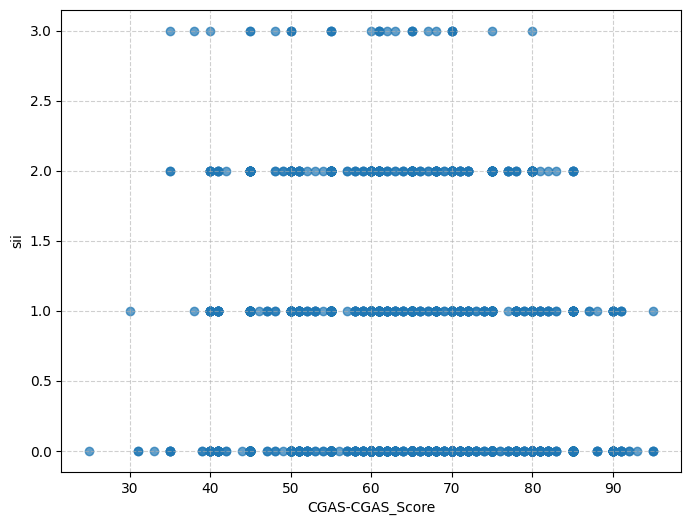

In [18]:
plt.figure(figsize=(8, 6))
plt.scatter(train['CGAS-CGAS_Score'], train['sii'], alpha=0.7)
plt.title('')
plt.ylabel('sii')
plt.xlabel('CGAS-CGAS_Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Có thể thấy rằng nhãn 'sii' không quá phụ thuộc vào dữ liệu ở 'CGAS-CGAS_Score'. Tuy nhiên, nó vẫn có thể sẽ hữu ích.

## Demographics (3 cols):
Thông tin về 'đối tượng thí nghiệm'
- 'Basic_Demos-Enroll_Season': mùa đo.
- 'Basic_Demos-Age': tuổi.
- 'Basic_Demos-Sex': giới tính

Này chắc k cần nói gì nhiều. Có thể nó sẽ liên quan đến sii (càng lớn tuổi thì càng dễ nghiện, nhưng lớn hơn thì ít lại, Kumo đoán vậy).

In [19]:
BD_cols = data_dict[data_dict['Instrument'] == "Demographics"]['Field']
for col in BD_cols:
    print(f" Missing percent of {col}: {missing_percentage(df=train, column_name=col)}")

 Missing percent of Basic_Demos-Enroll_Season: 0.0
 Missing percent of Basic_Demos-Age: 0.0
 Missing percent of Basic_Demos-Sex: 0.0


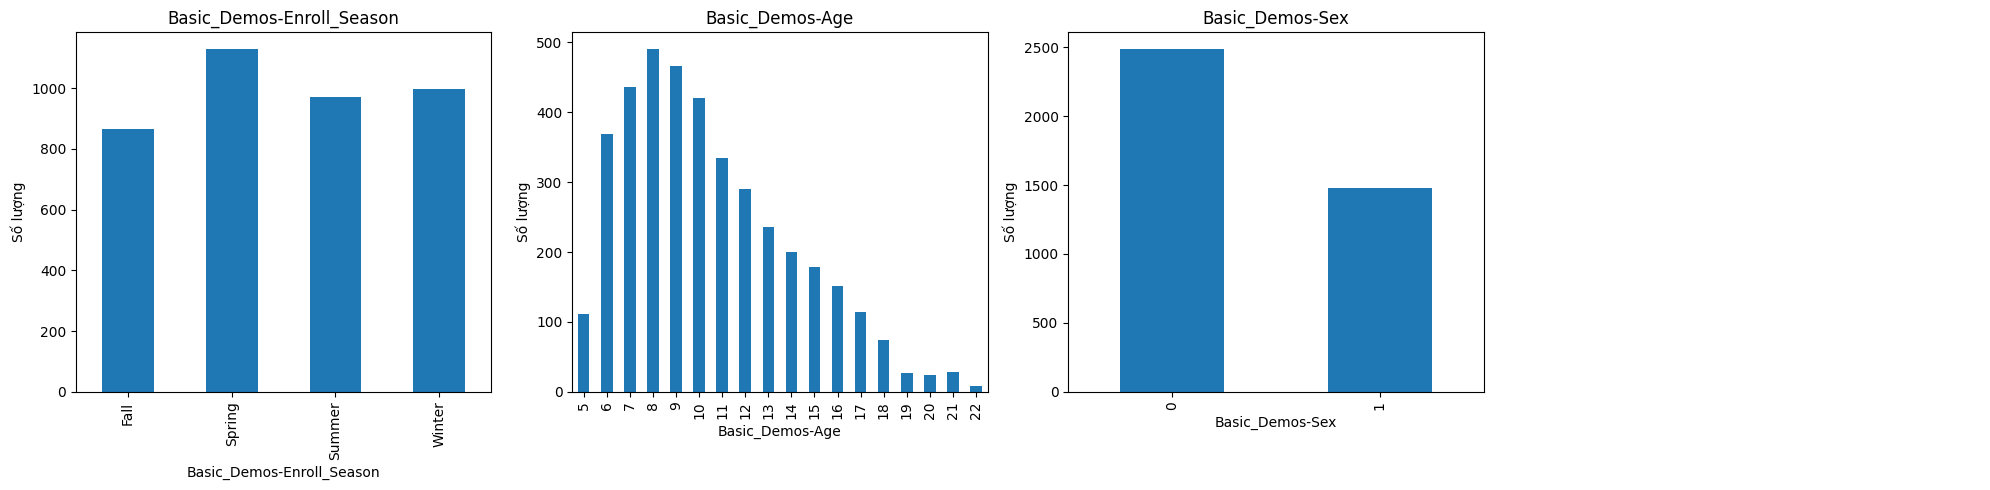

In [20]:
plot_related_cols(train, BD_cols)

Dữ liệu về mùa thì vẫn cân bằng. Tuy nhiên ở 2 cột còn lại có thể thấy số lượng trẻ em (children) nhiều hơn số lượng thanh niên (adolescent) và những người tham gia với giới tính 0 nhiều hơn khoảng 1000 mẫu so với người tham gia với giới tính 1.

## FitnessGram Child (15 cols): 
Đánh giá thể lực liên quan đến sức khỏe bằng các bài tập thể dục.
- 'FGC-Season': Mùa đo
- 'FGC-FGC_CU': Số lần gập bụng.
- 'FGC-FGC_CU_Zone': 0-1: Cần cải thiện - Healthy.
- 'FGC-FGC_GSND': Số lần nắm bàn tay không thuận.
- 'FGC-FGC_GSND_Zone': 1-2-3: week - normal - strong
- 'FGC-FGC_GSD': Số lần nắm bàn tay thuận.
- 'FGC-FGC_GSD_Zone': 1-2-3
- 'FGC-FGC_PU': Hít đất.
- 'FGC-FGC_PU_Zone': 0-1
- 'FGC-FGC_SRL': Ngồi xuống, duỗi chân thẳng ra rồi vươn tay tới phía bên trái.
- 'FGC-FGC_SRL_Zone': 0-1
- 'FGC-FGC_SRR': Ngồi xuống, duỗi chân thẳng ra rồi vươn tay tới phía bên phải.
- 'FGC-FGC_SRR_Zone': 0-1
- 'FGC-FGC_TL': Nằm sấp xuống rồi nhấc cái đầu cao lên :v
- 'FGC-FGC_TL_Zone': 0-1

In [21]:
FGC_cols = data_dict[data_dict['Instrument'] == "FitnessGram Child"]['Field']
for col in FGC_cols:
    print(f" Missing percent of {col}: {missing_percentage(df=train, column_name=col)}")

 Missing percent of FGC-Season: 15.505050505050505
 Missing percent of FGC-FGC_CU: 41.36363636363637
 Missing percent of FGC-FGC_CU_Zone: 42.37373737373738
 Missing percent of FGC-FGC_GSND: 72.87878787878788
 Missing percent of FGC-FGC_GSND_Zone: 73.18181818181819
 Missing percent of FGC-FGC_GSD: 72.87878787878788
 Missing percent of FGC-FGC_GSD_Zone: 73.15656565656565
 Missing percent of FGC-FGC_PU: 41.66666666666667
 Missing percent of FGC-FGC_PU_Zone: 42.65151515151515
 Missing percent of FGC-FGC_SRL: 41.792929292929294
 Missing percent of FGC-FGC_SRL_Zone: 42.75252525252525
 Missing percent of FGC-FGC_SRR: 41.74242424242424
 Missing percent of FGC-FGC_SRR_Zone: 42.7020202020202
 Missing percent of FGC-FGC_TL: 41.313131313131315
 Missing percent of FGC-FGC_TL_Zone: 42.29797979797979


Có thể thấy các features này missing không quá nhiều trừ bài tập GSND và GSD (missing hơn 70%) và 2 bài tập này có cách đánh giá khác hẳn so với những bài còn lại nên có thể cân nhắc không sử dụng.

Các features này chủ yếu để đánh giá thể lực của 1 người tham gia nên có thể tạo một features mới tổng hợp từ các cột này và sử dụng thay cho các features này để mô hình bớt phức tạp, tránh overfiting.

In [22]:
train[FGC_cols].describe()

,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone
count,2322.000000,2282.000000,1074.000000,1062.000000,1074.000000,1063.000000,2310.000000,2271.000000,2305.000000,2267.000000,2307.000000,2269.000000,2324.000000,2285.000000
mean,11.259690,0.476337,22.420438,1.829567,23.518622,1.904045,5.579654,0.330251,8.694924,0.618880,8.805635,0.620097,9.252775,0.785558
std,11.807781,0.499549,10.833995,0.612585,11.148951,0.612344,7.390161,0.470407,3.429301,0.485769,3.422167,0.485469,2.988863,0.410525
min,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,15.100000,1.000000,16.200000,2.000000,0.000000,0.000000,7.000000,0.000000,7.000000,0.000000,7.000000,1.000000
50%,9.000000,0.000000,20.050000,2.000000,21.200000,2.000000,3.000000,0.000000,9.000000,1.000000,9.000000,1.000000,10.000000,1.000000
75%,15.750000,1.000000,26.600000,2.000000,28.175000,2.000000,9.000000,1.000000,11.000000,1.000000,11.000000,1.000000,12.000000,1.000000
max,115.000000,1.000000,124.000000,3.000000,123.800000,3.000000,51.000000,1.000000,21.700000,1.000000,21.000000,1.000000,22.000000,1.000000


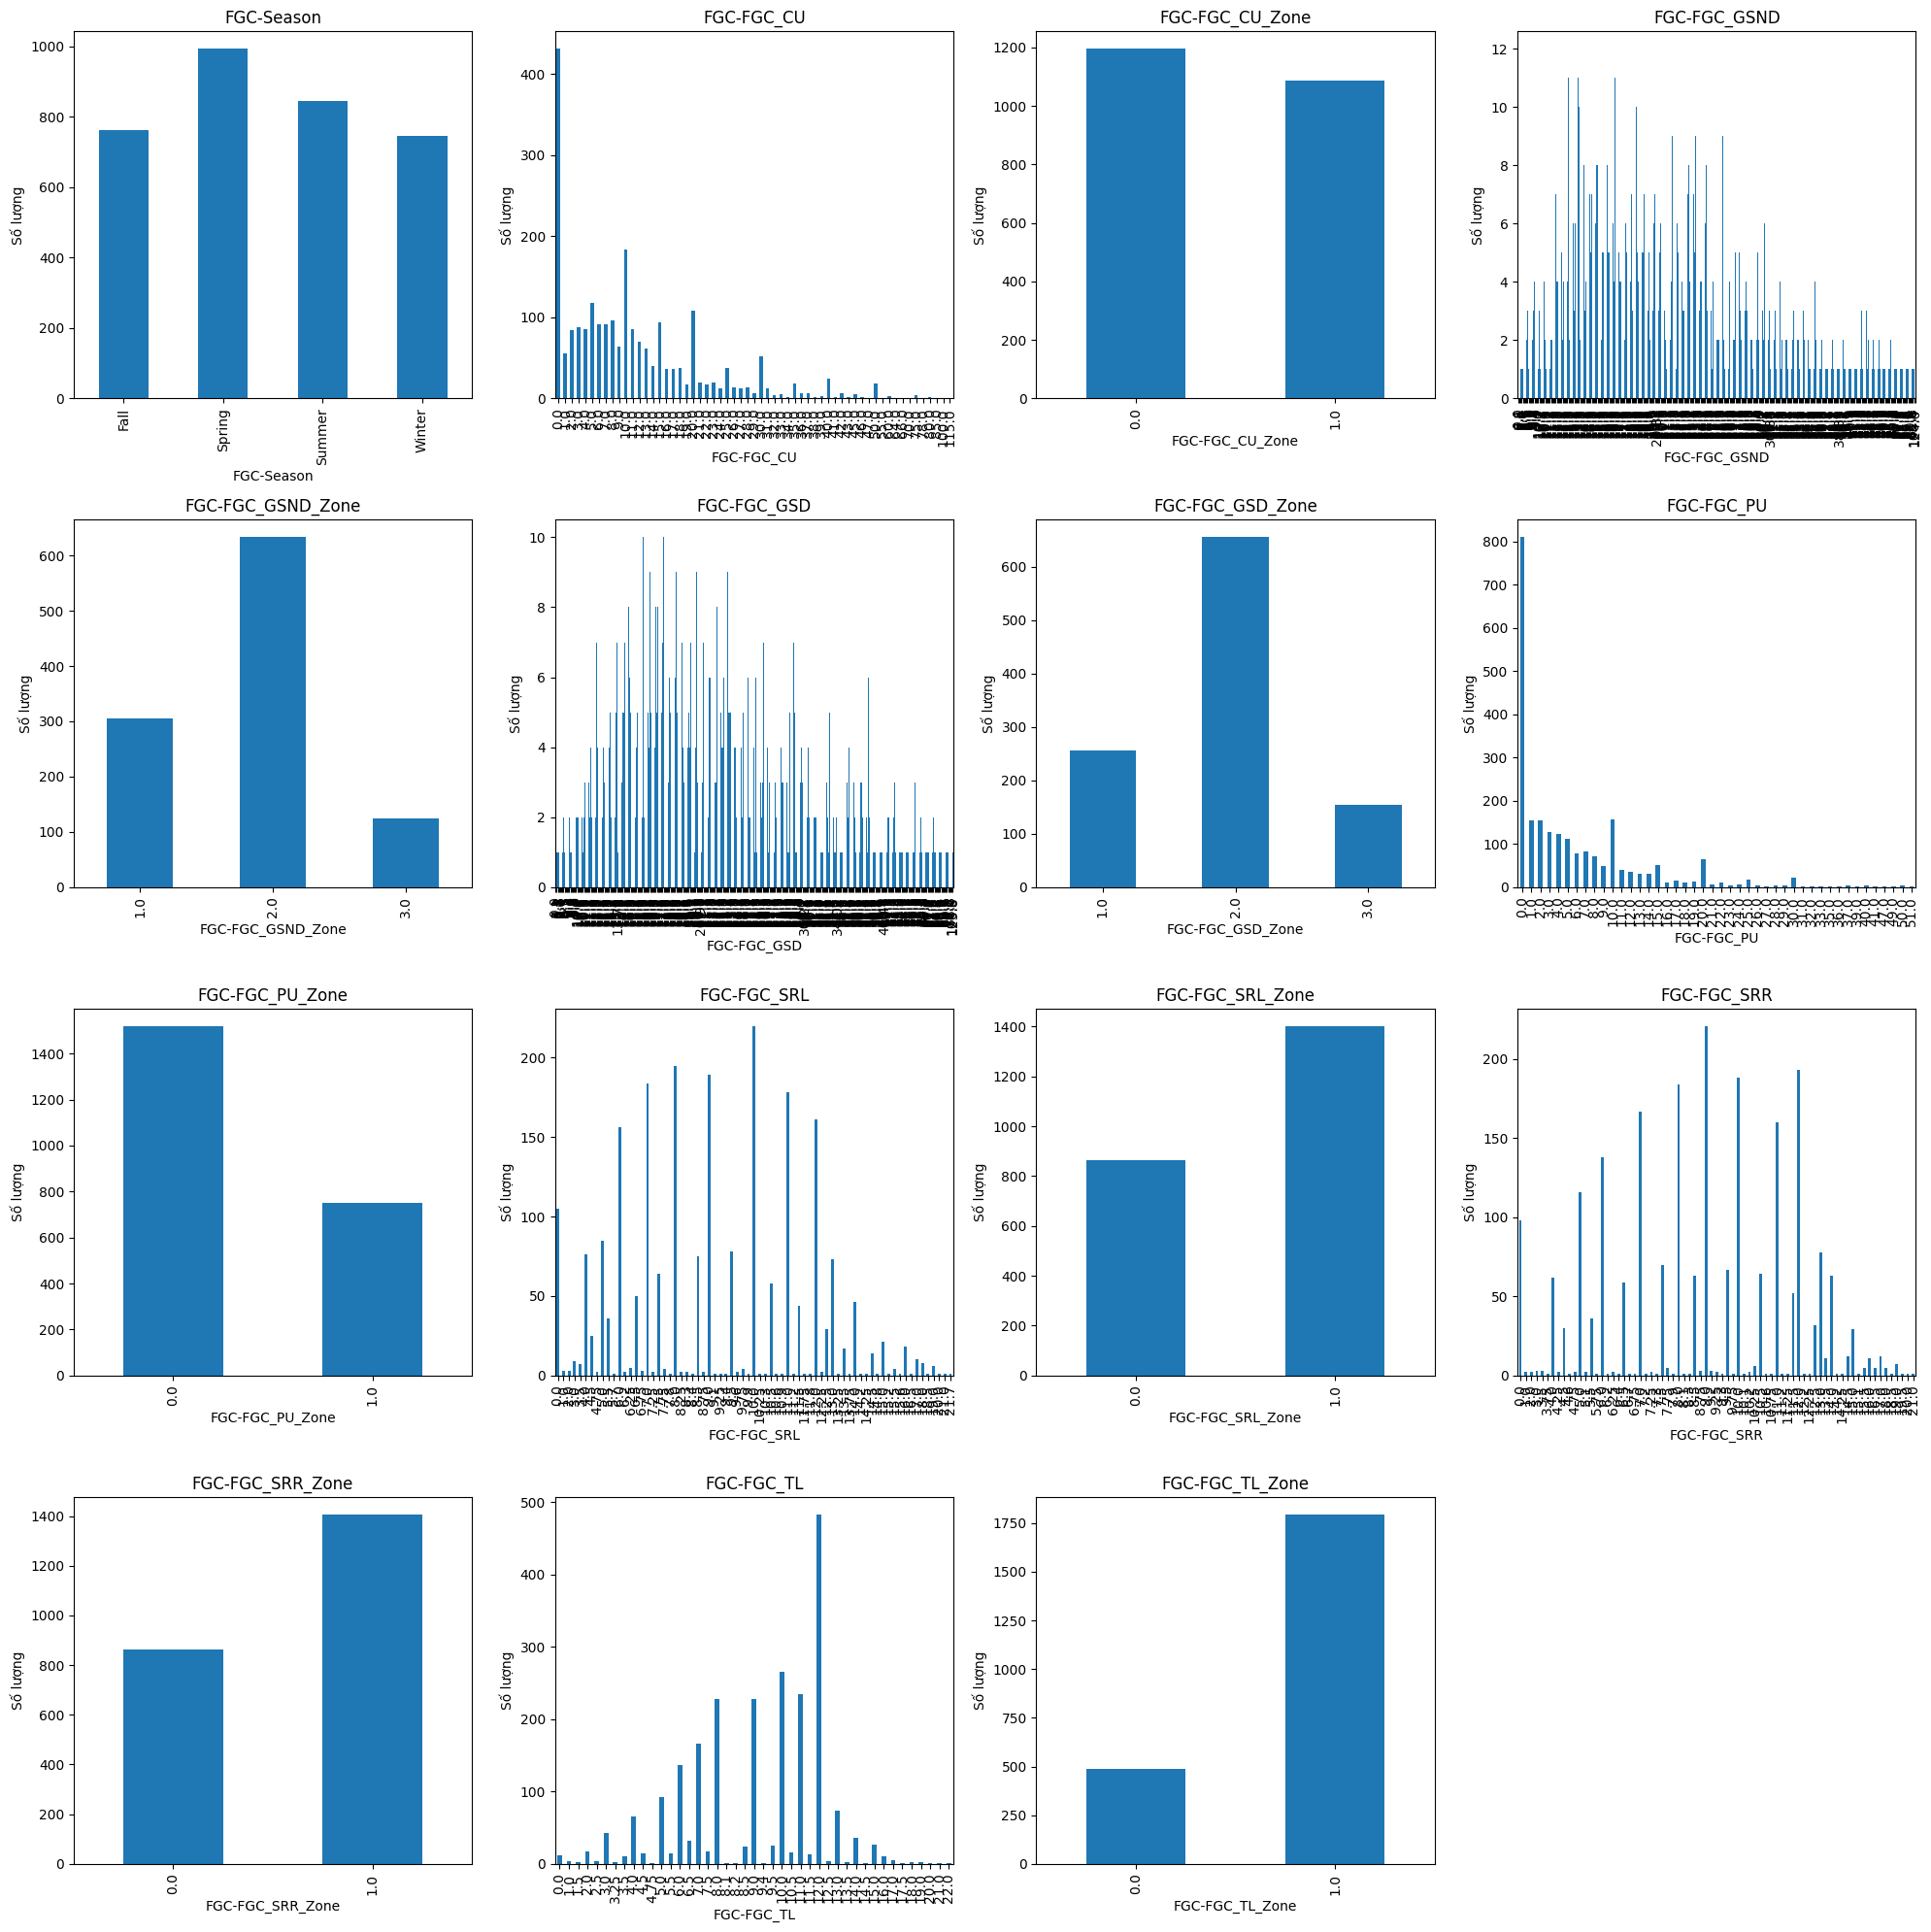

In [23]:
plot_related_cols(train, FGC_cols)

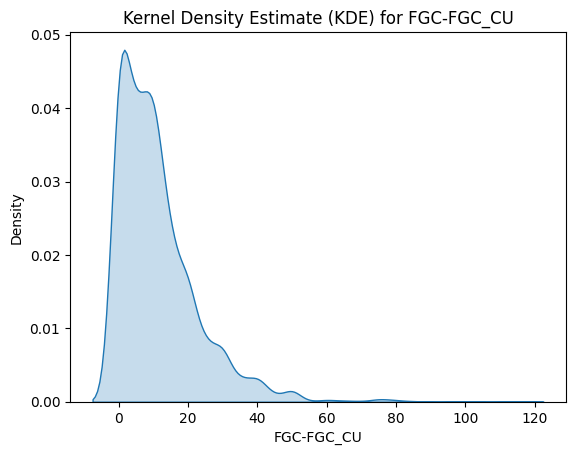

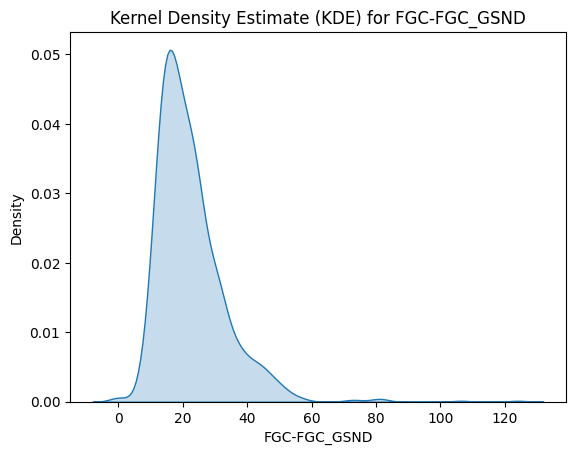

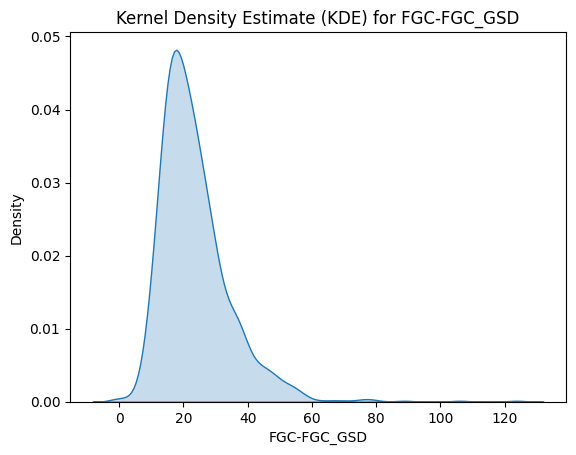

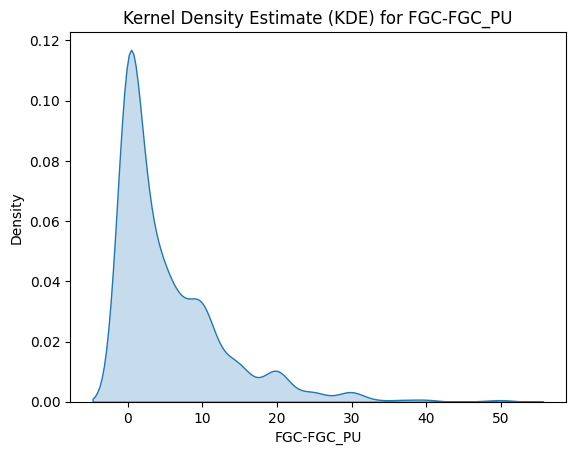

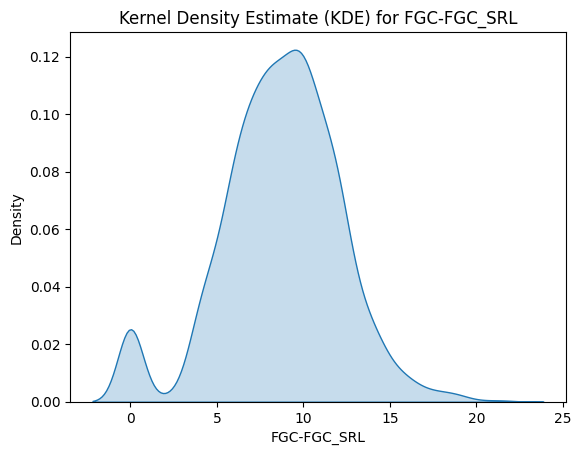

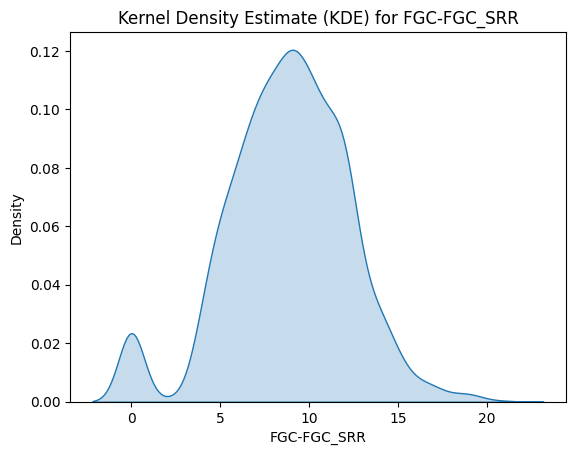

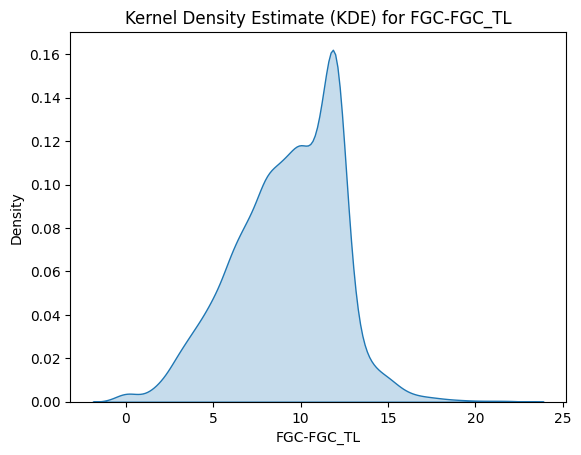

In [24]:
# Phân bố thể lực
for col in FGC_cols:
    if 'Season' not in col and 'Zone' not in col:
        plot_kde(train, col)

## FitnessGram Vitals and Treadmill (4 cols): 
Đánh giá sức khỏe tim mạch bằng cách sử dụng giao thức máy chạy bộ NHANES.
- 'Fitness_Endurance-Season': Mùa đo
- 'Fitness_Endurance-Max_Stage': Stage tối đa đạt được.
- 'Fitness_Endurance-Time_Mins': Thời gian hoàn thành tính đến phút.
- 'Fitness_Endurance-Time_Sec': Thời gian hoàn thành tính đến giây.

In [25]:
# Miss nhiều quả nên cho nghỉ, maybe cái trên cũng sẽ khong cần xài tới.
FE_cols = data_dict[data_dict['Instrument'] == "FitnessGram Vitals and Treadmill"]['Field']
for col in FE_cols:
    print(f" Missing percent of {col}: {missing_percentage(df=train, column_name=col)}")

 Missing percent of Fitness_Endurance-Season: 66.96969696969697
 Missing percent of Fitness_Endurance-Max_Stage: 81.23737373737374
 Missing percent of Fitness_Endurance-Time_Mins: 81.31313131313132
 Missing percent of Fitness_Endurance-Time_Sec: 81.31313131313132


Do các features này missing quá nhiều (>80%) và về ý nghĩa thì nó cũng gần giống với FitnessGram Child nên có thể cân nhắc không sử dụng.

## Identify (1 cols):
ID của người tham gia, không nên sử dụng trong mô hình

## Internet Use (2 cols):
- 'PreInt_EduHx-Season': Mùa đo.
- 'PreInt_EduHx-computerinternet_hoursday': Số giờ sử dụng máy tính/internet mỗi ngày.

In [26]:
IU_cols = data_dict[data_dict['Instrument'] == "Internet Use"]['Field']
for col in IU_cols:
    print(f" Missing percent of {col}: {missing_percentage(df=train, column_name=col)}")

 Missing percent of PreInt_EduHx-Season: 10.606060606060606
 Missing percent of PreInt_EduHx-computerinternet_hoursday: 16.641414141414142


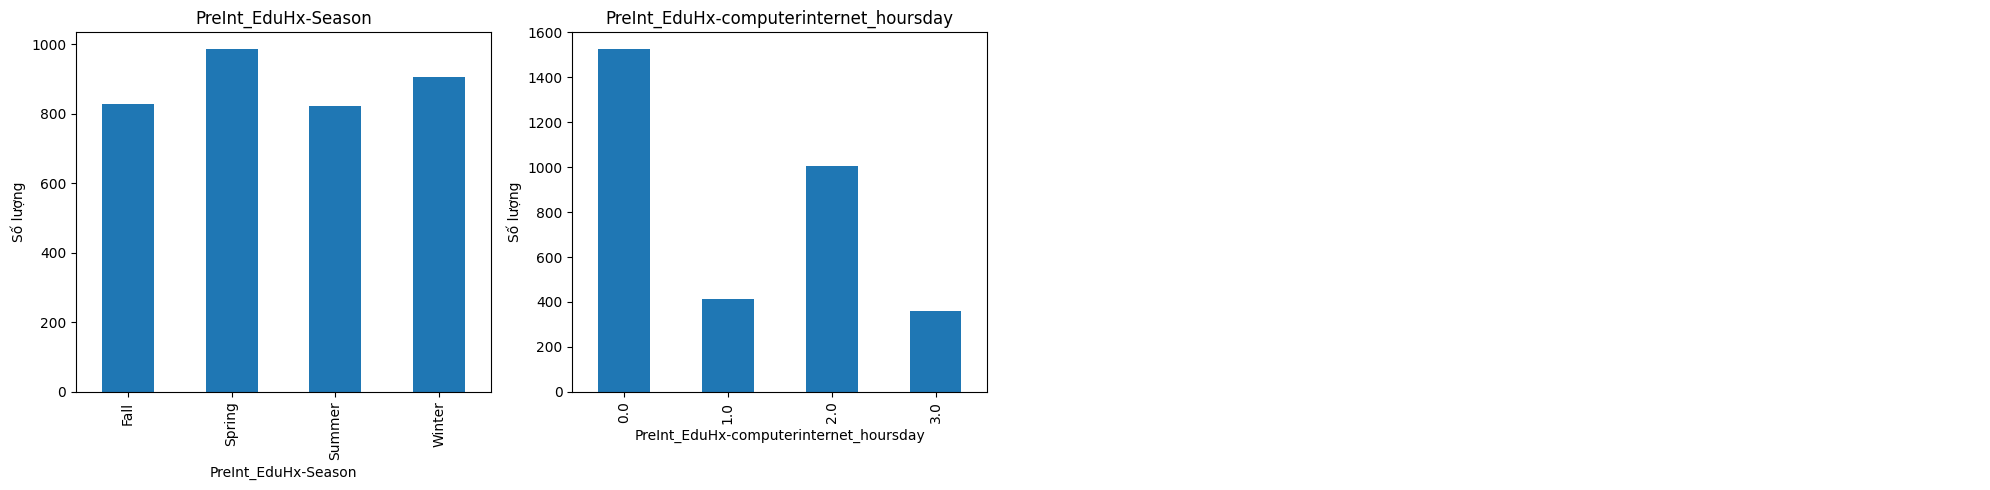

In [27]:
plot_related_cols(train, IU_cols)

Phân bố của mùa vẫn đồng đều, trong khi phân bố của 'PreInt_EduHx-computerinternet_hoursday' thì hơi mất cân bằng về phía 0.

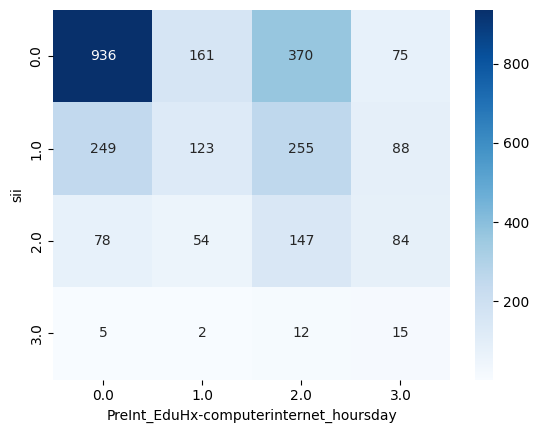

In [28]:
confusion_matrix = pd.crosstab(train['sii'], train['PreInt_EduHx-computerinternet_hoursday'], rownames=['sii'], colnames=['PreInt_EduHx-computerinternet_hoursday'])
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.show()

## Physical Activity Questionnaire (Adolescents + Children) (4 cols):
Thông tin về sự tham gia của người tham gia (trẻ em và thanh niên) vào các hoạt động mạnh trong 7 ngày qua.
- 'PAQ_A-Season'
- 'PAQ_A-PAQ_A_Total'
- 'PAQ_C-Season'
- 'PAQ_C-PAQ_C_Total'

In [29]:
PAQ_A_cols = data_dict[data_dict['Instrument'] == "Physical Activity Questionnaire (Adolescents)"]['Field']
for col in PAQ_A_cols:
    print(f" Missing percent of {col}: {missing_percentage(df=train, column_name=col)}")

 Missing percent of PAQ_A-Season: 88.0050505050505
 Missing percent of PAQ_A-PAQ_A_Total: 88.0050505050505


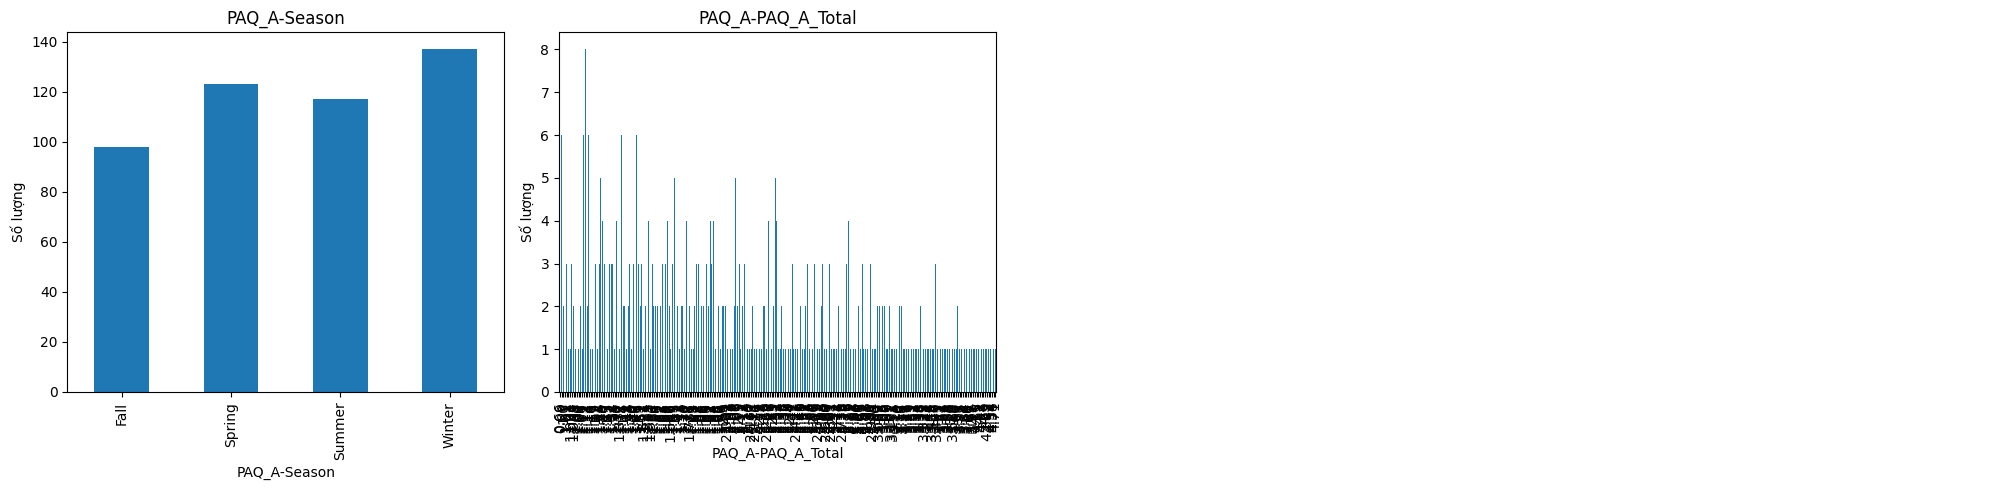

In [30]:
plot_related_cols(train, PAQ_A_cols)

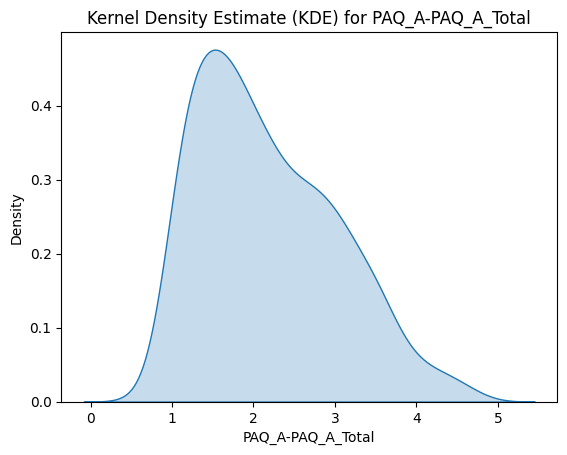

In [31]:
plot_kde(train, 'PAQ_A-PAQ_A_Total')

In [32]:
PAQ_C_cols = data_dict[data_dict['Instrument'] == "Physical Activity Questionnaire (Children)"]['Field']
for col in PAQ_C_cols:
    print(f" Missing percent of {col}: {missing_percentage(df=train, column_name=col)}")

 Missing percent of PAQ_C-Season: 56.540404040404034
 Missing percent of PAQ_C-PAQ_C_Total: 56.540404040404034


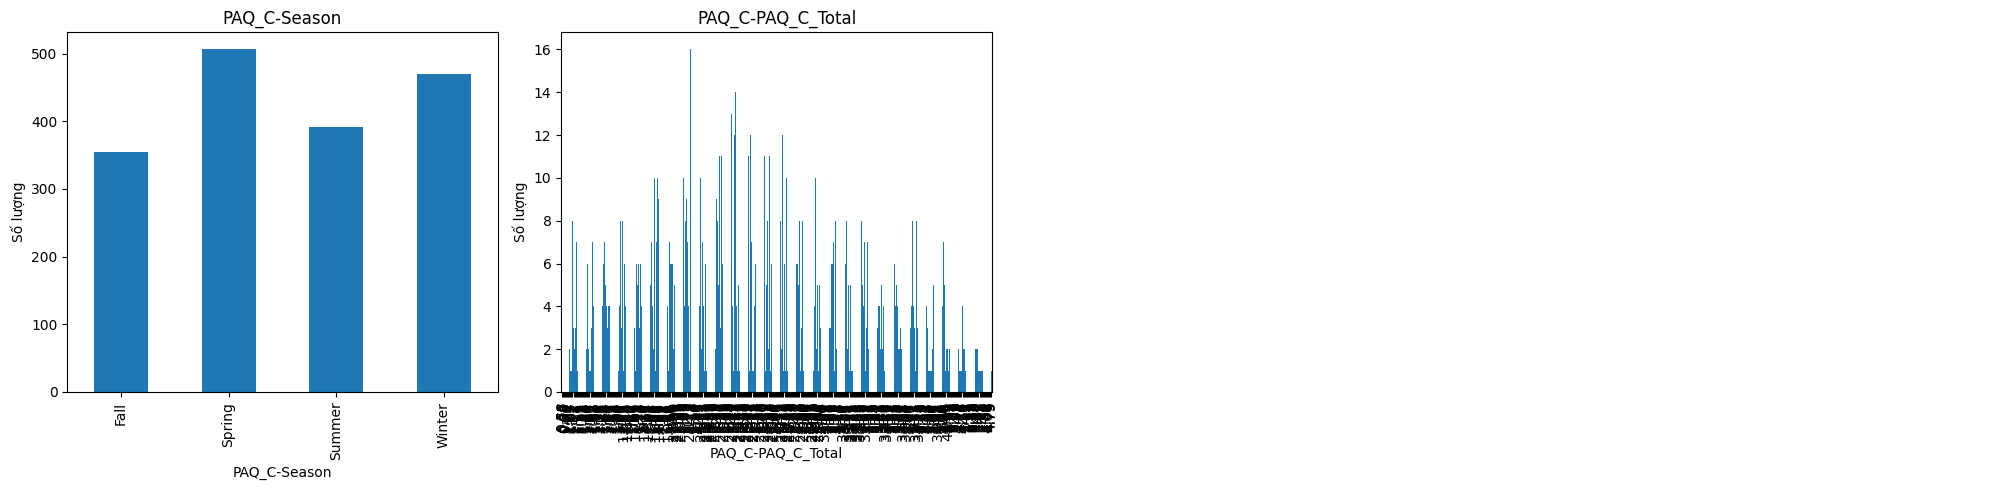

In [33]:
plot_related_cols(train, PAQ_C_cols)

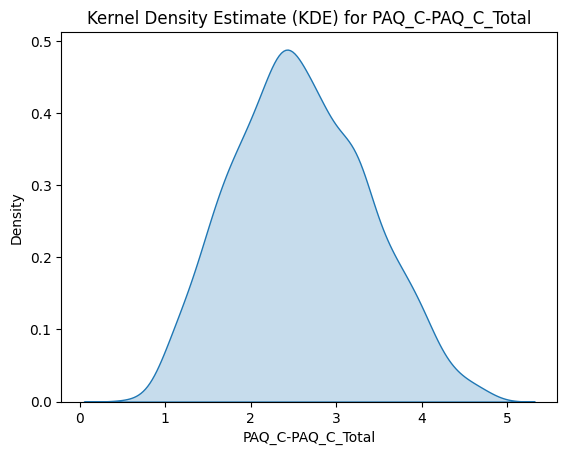

In [34]:
plot_kde(train, 'PAQ_C-PAQ_C_Total')

In [35]:
print(len(train[train['PAQ_C-PAQ_C_Total'].notna() & train['PAQ_A-PAQ_A_Total'].notna()]))
print(len(train[train['PAQ_C-PAQ_C_Total'].isna() & train['PAQ_A-PAQ_A_Total'].isna() & train['sii'].notna()]))

1
934


In [36]:
train[train['PAQ_C-PAQ_C_Total'].notna() & train['PAQ_A-PAQ_A_Total'].notna()]

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
3331,d74e4d7c,Winter,13,1,NaN,NaN,Summer,24.094889,68.75,162.0,NaN,70.0,62.0,118.0,NaN,NaN,NaN,NaN,Fall,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2.27,Spring,2.32,Spring,5.0,4.0,4.0,1.0,5.0,1.0,0.0,2.0,1.0,2.0,3.0,0.0,3.0,1.0,2.0,1.0,3.0,2.0,3.0,2.0,45.0,Winter,52.0,72.0,Winter,3.0,1.0


Do 2 cột '_Total' của PAQ đo với 2 đối tượng khác nhau nên có thể tạo một feature là kết hợp 2 cột này lại. Tuy nhiên, có 1 người tham gia (d74e4d7c) có cả 2 chỉ số và người đó 13 tuổi nên có thể sử dụng cột 'PAQ_C-PAQ_C_Total'.

In [37]:
# Định nghĩa hàm kết hợp 2 cột
def combine_columns(col1, col2):
    return col1.combine(col2, lambda x, y: x if pd.notna(x) and pd.notna(y) 
                        else x if pd.notna(x) 
                        else y if pd.notna(y)
                        else np.nan)

train['PAQ_Combine'] = combine_columns(train['PAQ_C-PAQ_C_Total'], train['PAQ_A-PAQ_A_Total'])

In [38]:
print(f" Missing percent of 'PAQ_Combine': {missing_percentage(df=train, column_name='PAQ_Combine')}")

 Missing percent of 'PAQ_Combine': 44.57070707070707


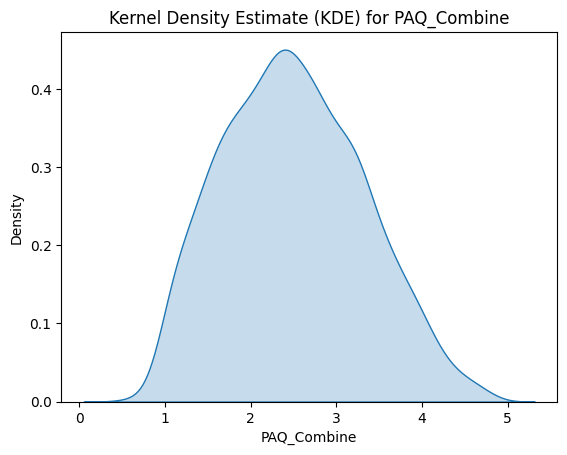

In [39]:
plot_kde(train, 'PAQ_Combine')

Phân bố cũng gần giống với phân phối chuẩn nên có thể điền mean, median vào giá trị NaN.

## Physical Measures (8 cols):
Thu thập số đo huyết áp, nhịp tim, chiều cao, cân nặng, vòng eo và hông.
- 'Physical-Season': Mùa đo
- 'Physical-BMI': Có giống cái trên không ta???
- 'Physical-Height': Chiều cao
- 'Physical-Weight': Cân nặng
- 'Physical-Waist_Circumference': Vòng eo
- 'Physical-Diastolic_BP': Huyết áp tâm trương, bình thường là 80 mmHg
- 'Physical-HeartRate': Nhịp <3
- 'Physical-Systolic_BP': Huyết áp tâm thu, bình thường là 120 mmHg

In [40]:
PM_cols = data_dict[data_dict['Instrument'] == "Physical Measures"]['Field']
for col in PM_cols:
    print(f" Missing percent of {col}: {missing_percentage(df=train, column_name=col)}")

 Missing percent of Physical-Season: 16.414141414141415
 Missing percent of Physical-BMI: 23.686868686868685
 Missing percent of Physical-Height: 23.56060606060606
 Missing percent of Physical-Weight: 22.32323232323232
 Missing percent of Physical-Waist_Circumference: 77.32323232323233
 Missing percent of Physical-Diastolic_BP: 25.40404040404041
 Missing percent of Physical-HeartRate: 25.075757575757574
 Missing percent of Physical-Systolic_BP: 25.40404040404041


In [41]:
train[PM_cols].describe()

,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP
count,3022.000000,3027.000000,3076.000000,898.000000,2954.000000,2967.000000,2954.000000
mean,19.331929,55.946713,89.038615,27.278508,69.648951,81.597236,116.983074
std,5.113934,7.473764,44.569040,5.567287,13.611226,13.665196,17.061225
min,0.000000,33.000000,0.000000,18.000000,0.000000,27.000000,0.000000
25%,15.869350,50.000000,57.200000,23.000000,61.000000,72.000000,107.000000
50%,17.937682,55.000000,77.000000,26.000000,68.000000,81.000000,114.000000
75%,21.571244,62.000000,113.800000,30.000000,76.000000,90.500000,125.000000
max,59.132048,78.500000,315.000000,50.000000,179.000000,138.000000,203.000000


'Physical-Waist_Circumference' bị miss khá nhiều nên có thể cân nhắc không sử dụng.
Có thể thấy rằng một số giá trị min và max có vẻ không hợp lý. Điều này được chứng minh tại các mốc 25%, 50%, 75%, giá trị không thay đổi quá nhiều nhưng giá trị min và max lại cách rất xa các giá trị này.

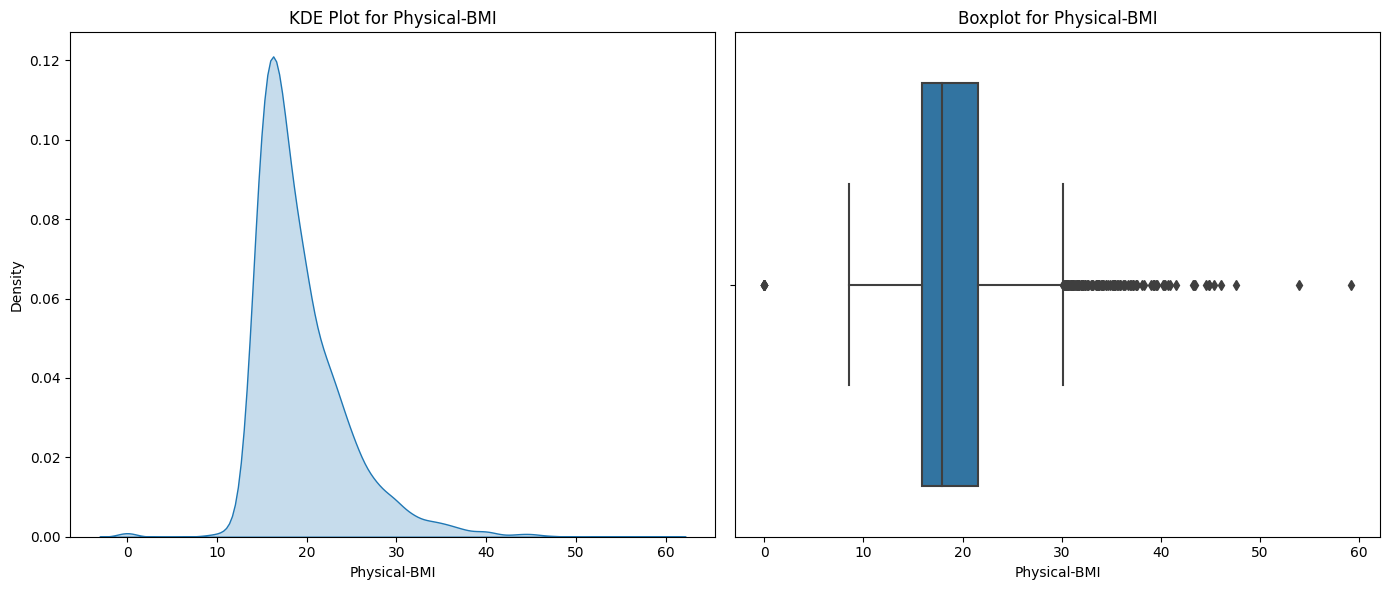

128


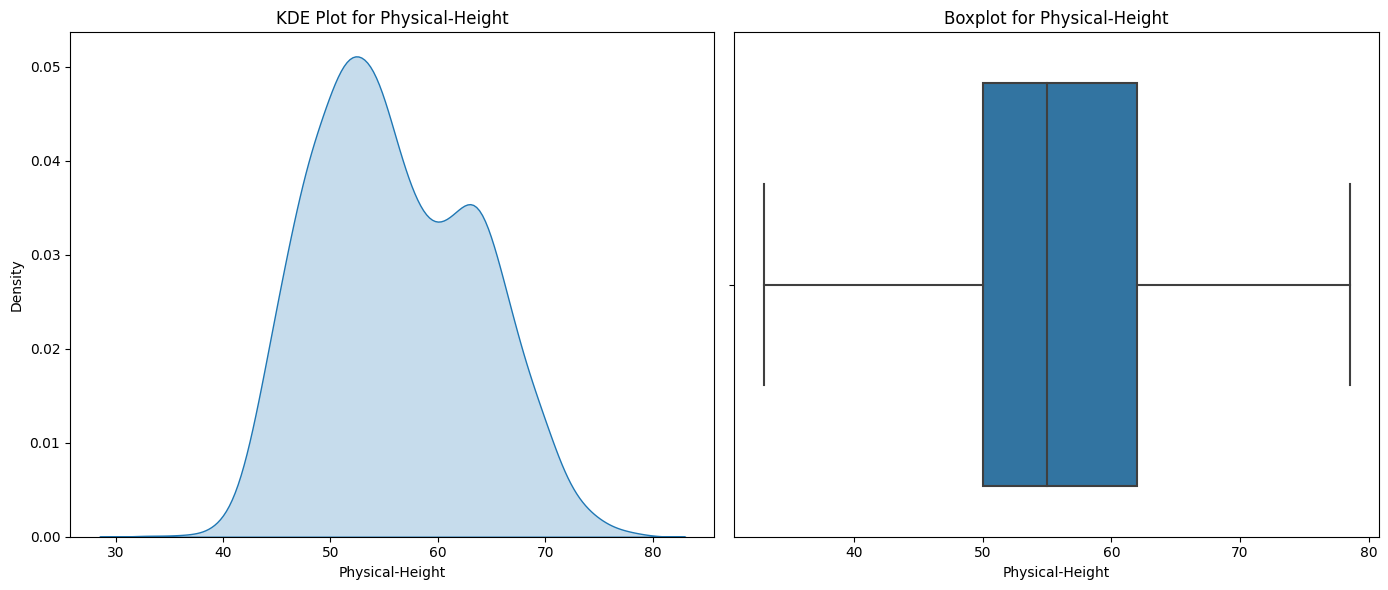

0


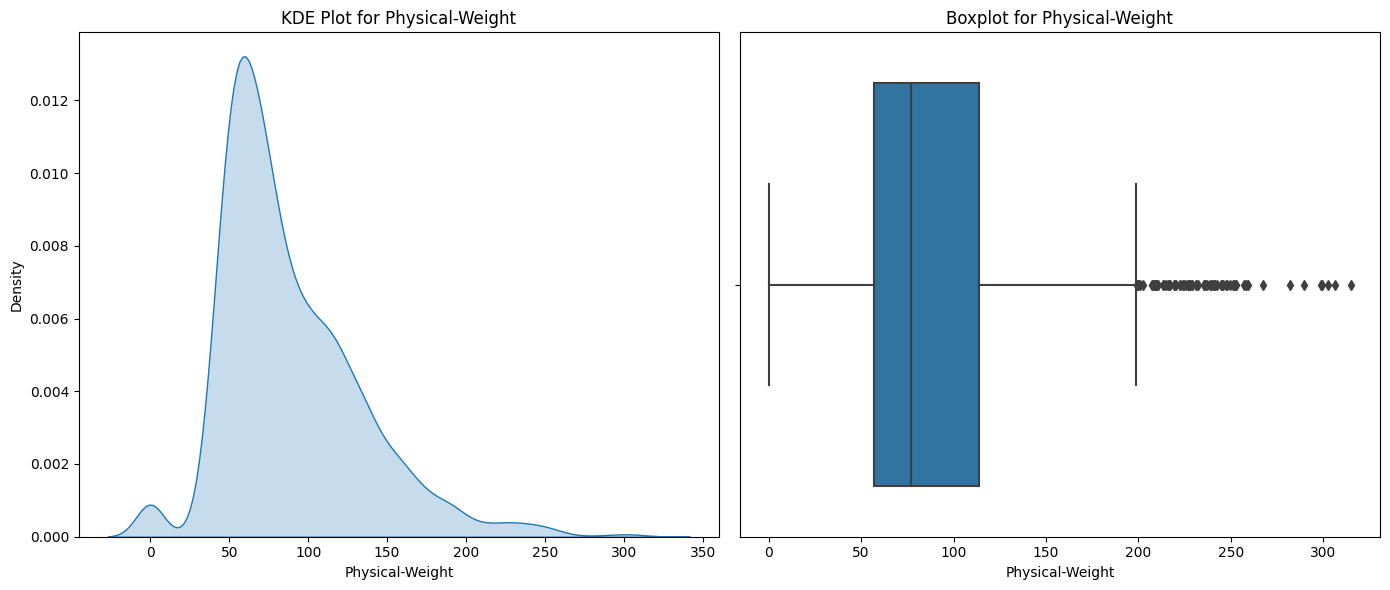

77


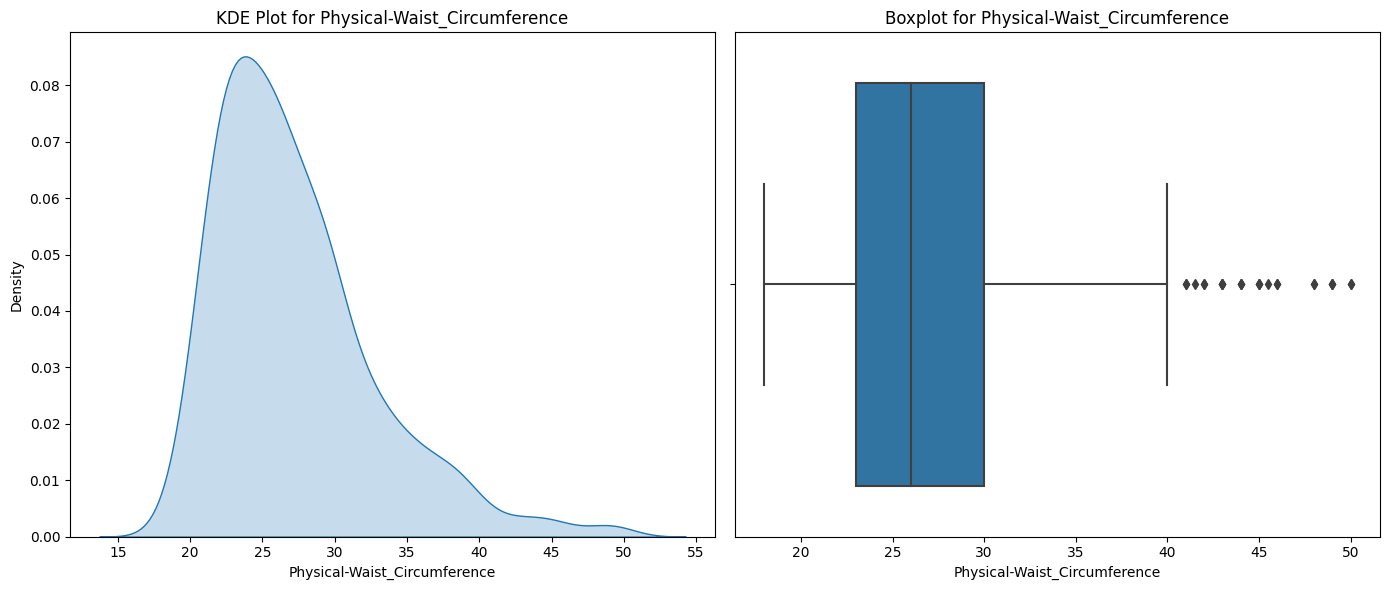

25


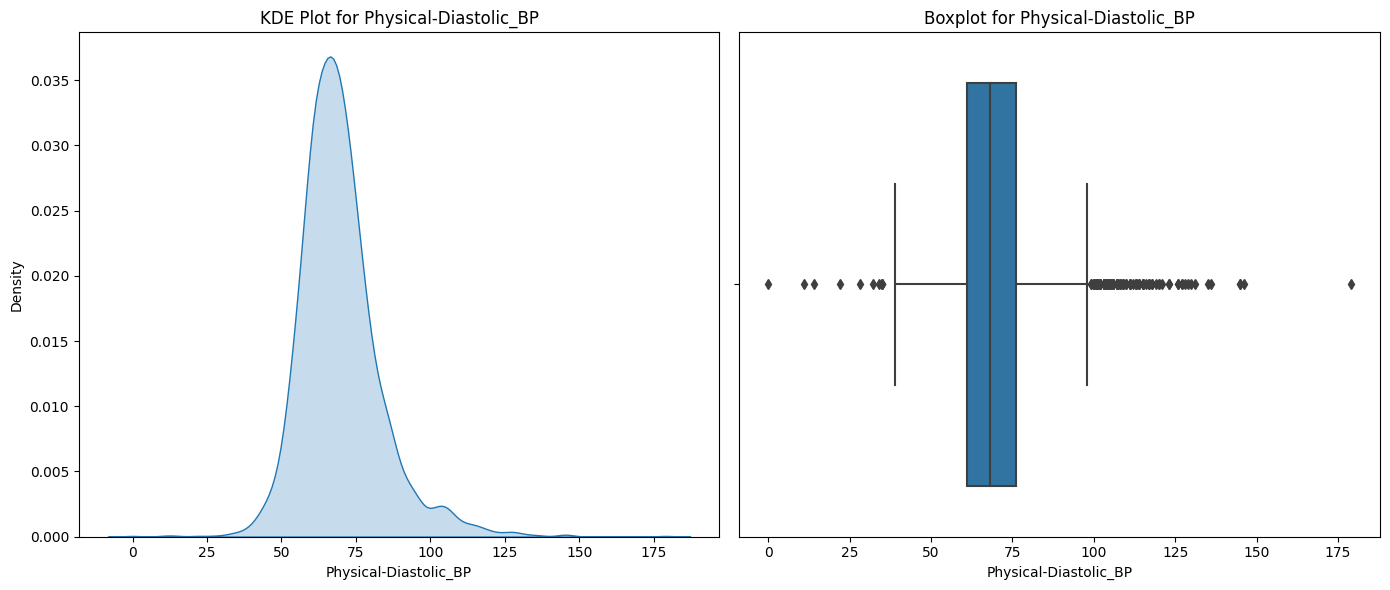

123


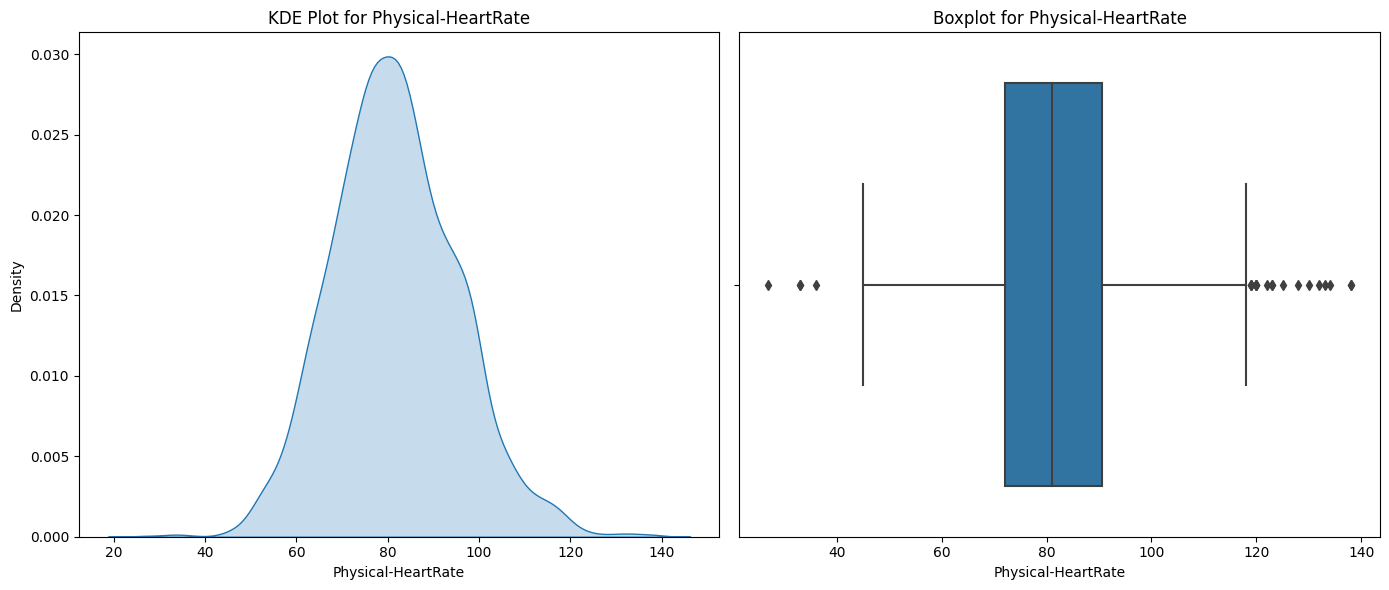

22


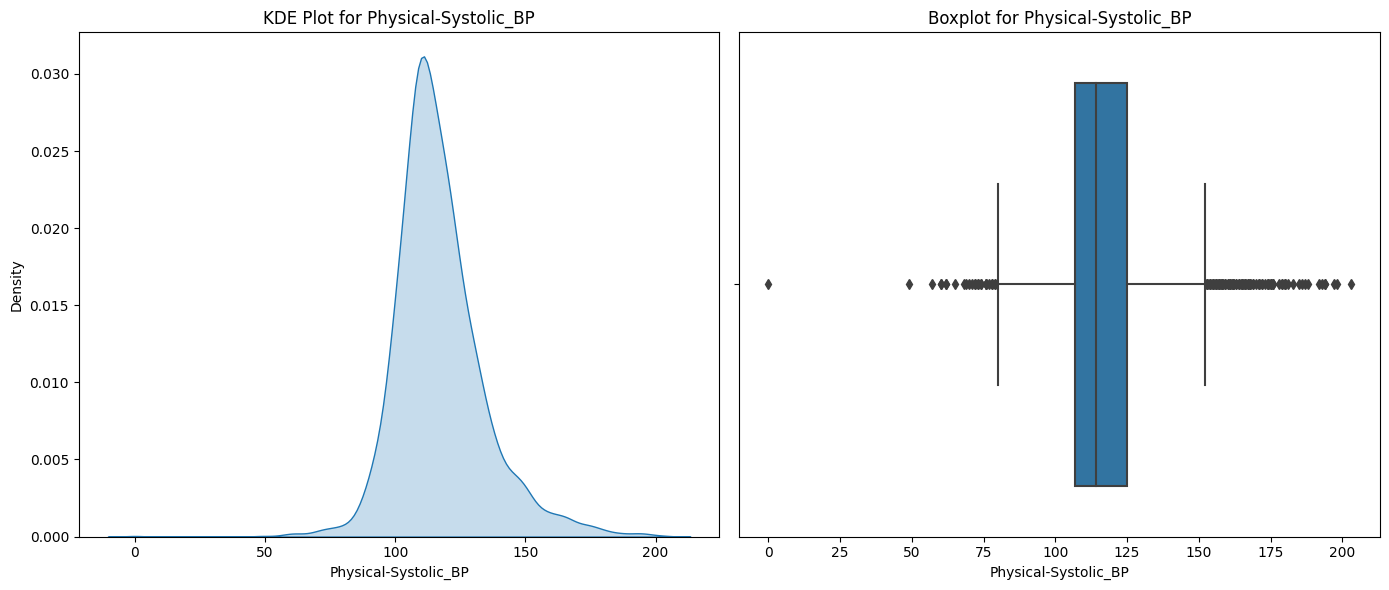

135


In [42]:
for col in PM_cols:
    if 'Season' not in col:
        outlier = plot_kde_and_box(train, col)
        # print(outlier)
        print(len(outlier))
        replace_value = train[col].median()

        train = replace_outliers(train, col, outlier, replace_value)

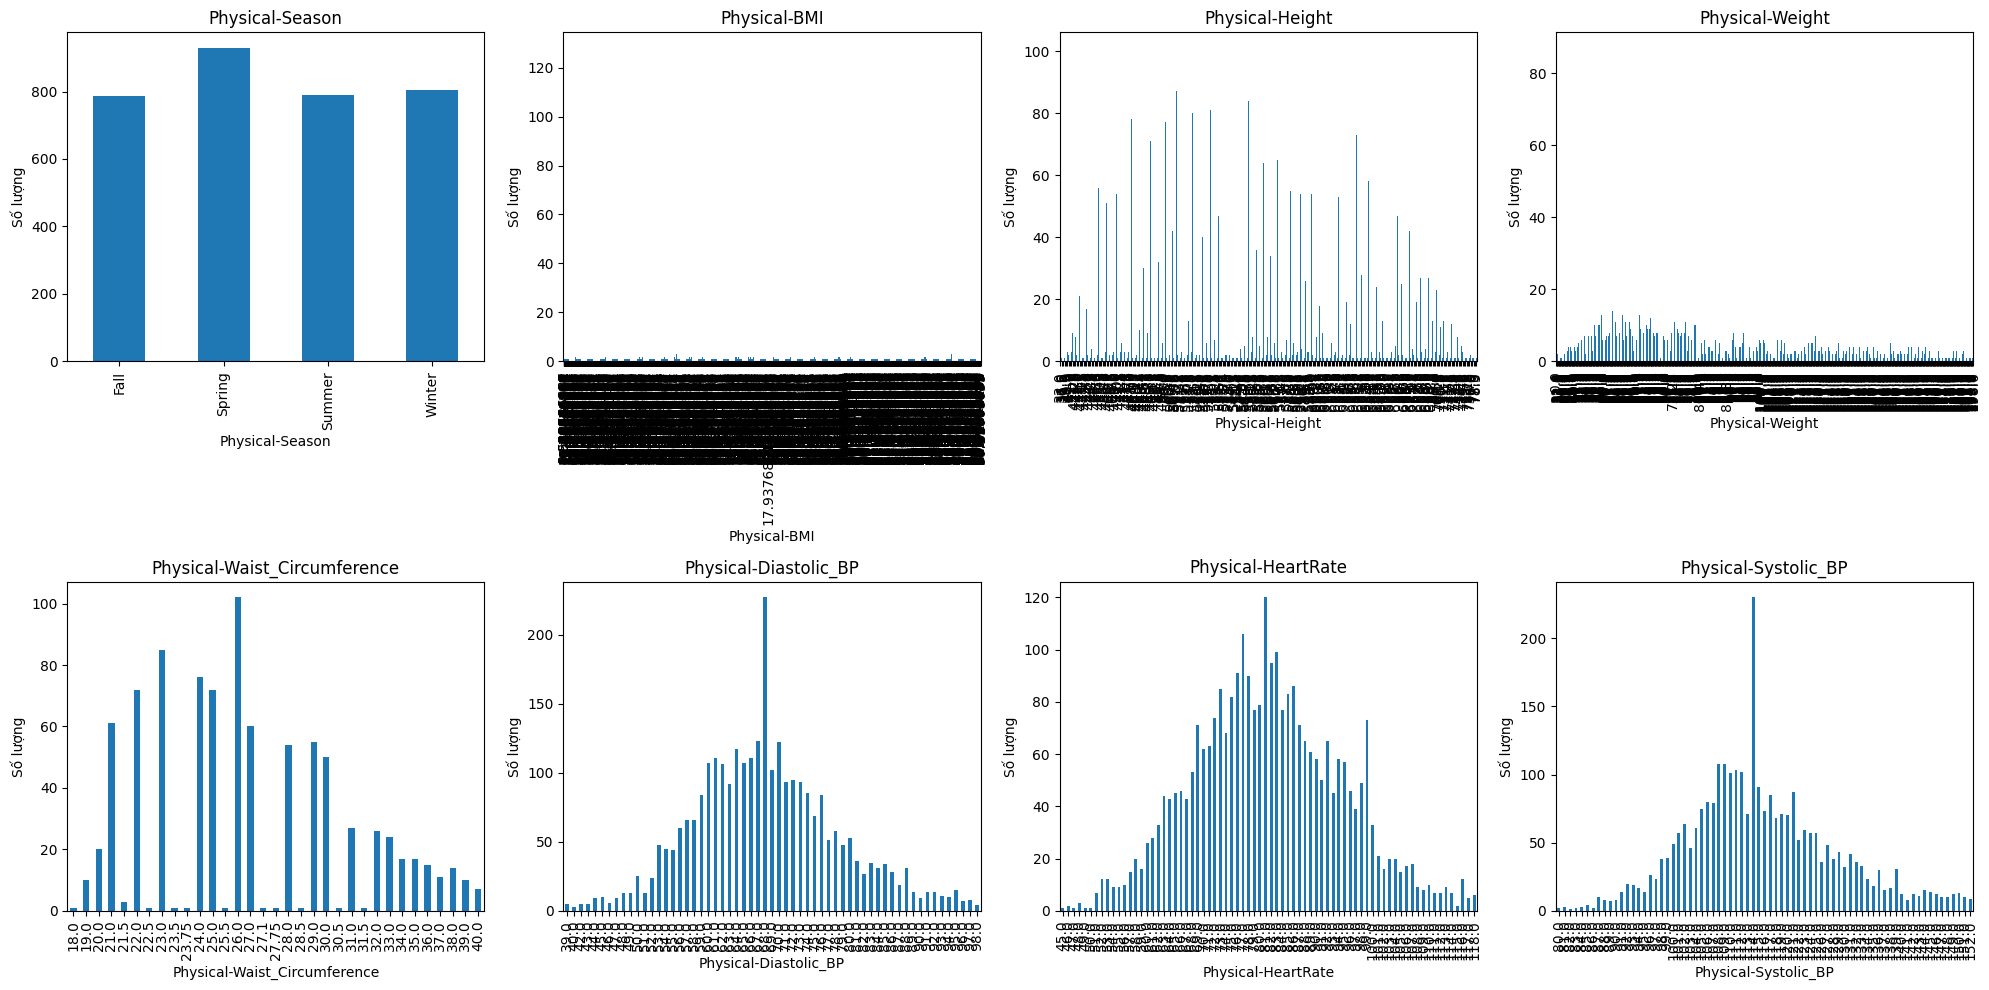

In [43]:
plot_related_cols(train, PM_cols)

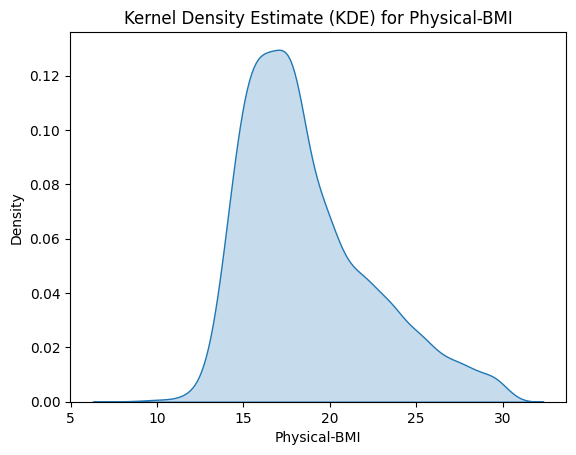

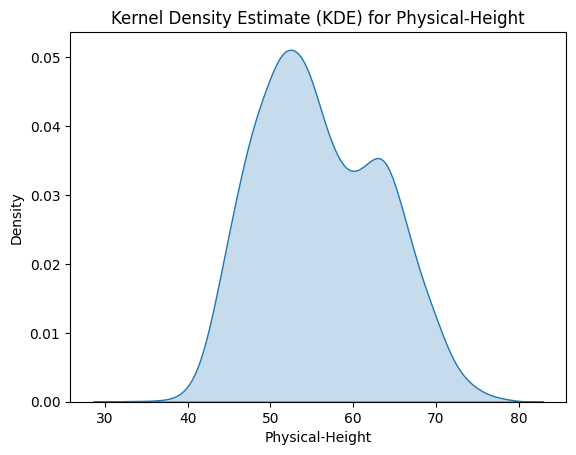

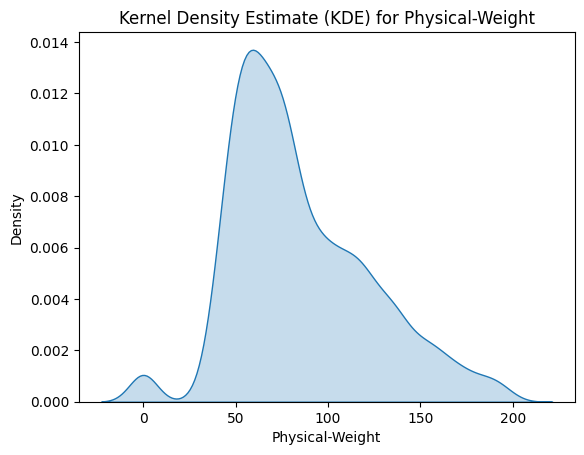

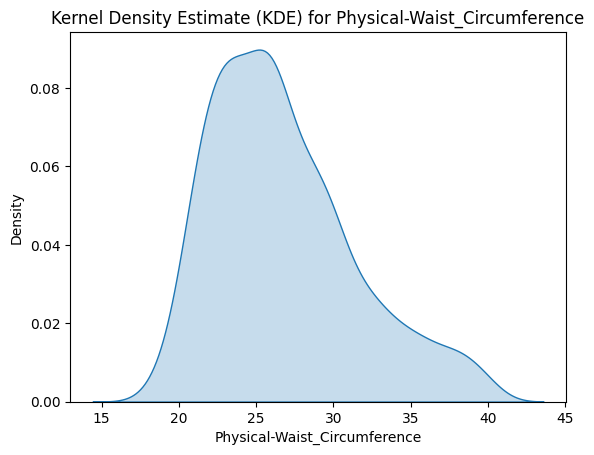

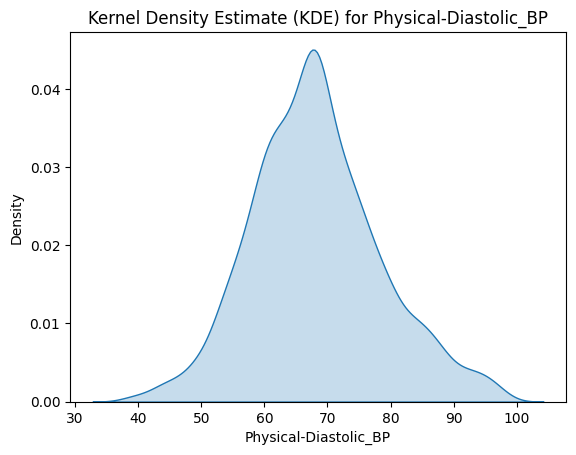

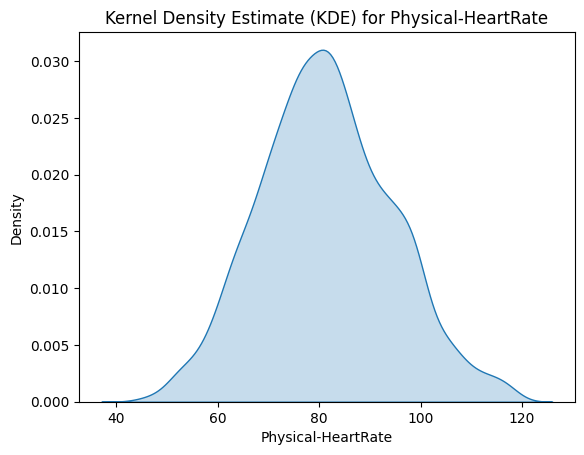

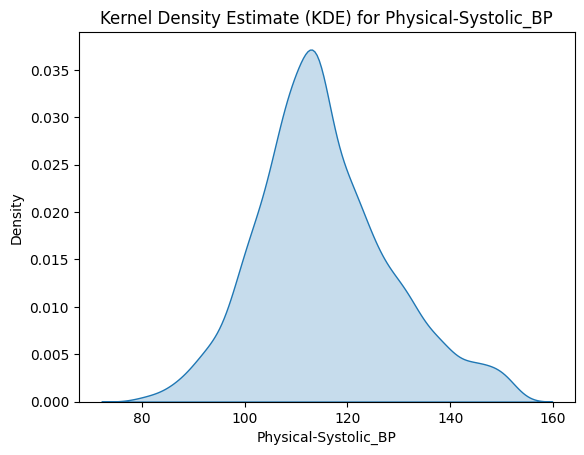

In [44]:
for col in PM_cols:
    if 'Season' not in col:
        plot_kde(train, col)

Phân bố của mùa vẫn khá đồng đều, còn các features còn lại sau khi loại bỏ outlier thì đã trông gần giống với phân phối chuẩn hơn.

## Sleep Disturbance Scale (3 cols):
Thang đo phân loại rối loạn giấc ngủ.
Bộ 26 câu hỏi, mỗi câu 1-5 điểm, raw là điểm gốc, T-score là điểm đã chuẩn hoá.
- 'SDS-Season': mùa đo
- 'SDS-SDS_Total_Raw'.
- 'SDS-SDS_Total_T'.

In [45]:
SDS_cols = data_dict[data_dict['Instrument'] == "Sleep Disturbance Scale"]['Field']
for col in SDS_cols:
    print(f" Missing percent of {col}: {missing_percentage(df=train, column_name=col)}")

 Missing percent of SDS-Season: 33.88888888888889
 Missing percent of SDS-SDS_Total_Raw: 34.11616161616162
 Missing percent of SDS-SDS_Total_T: 34.19191919191919


In [46]:
train[SDS_cols].describe()

,SDS-SDS_Total_Raw,SDS-SDS_Total_T
count,2609.000000,2606.000000
mean,41.088923,57.763622
std,10.427433,13.196091
min,17.000000,38.000000
25%,33.000000,47.000000
50%,39.000000,55.000000
75%,46.000000,64.000000
max,96.000000,100.000000


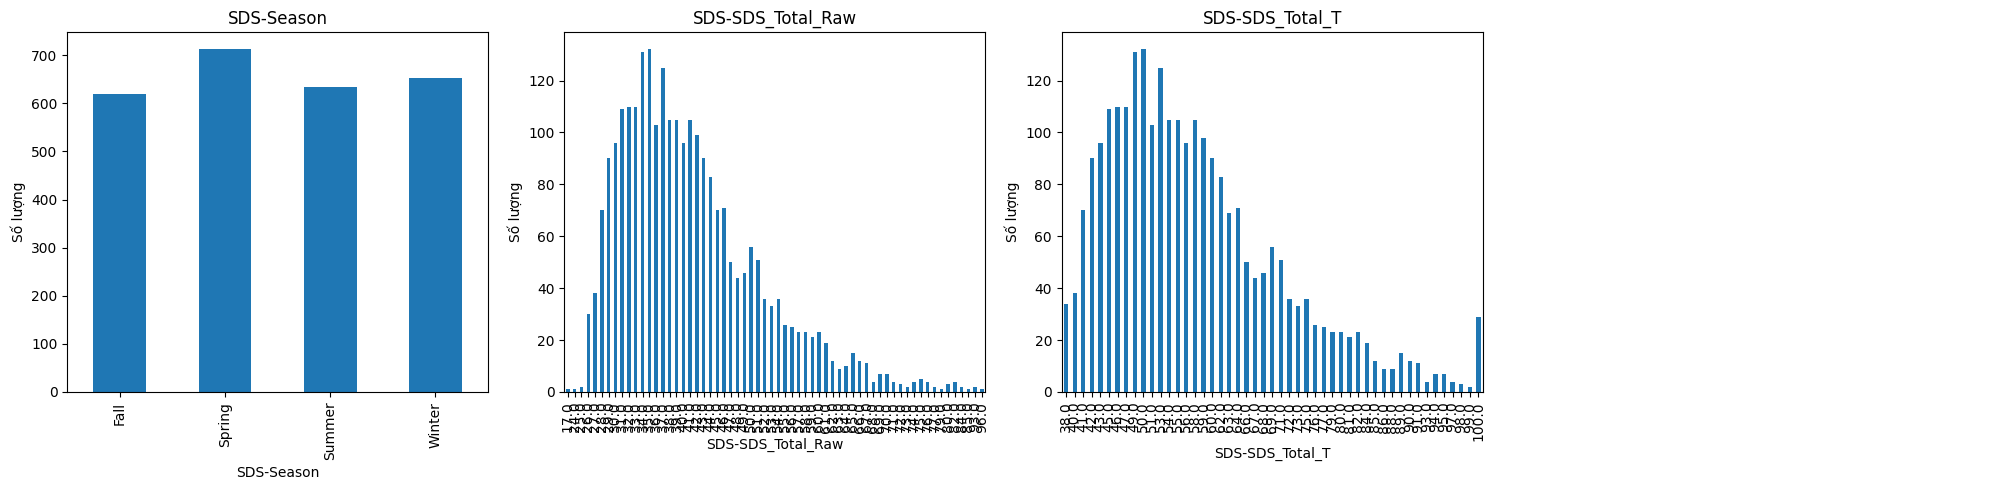

In [47]:
plot_related_cols(train, SDS_cols)

Về cơ bản thì 2 cột score này mang ý nghĩa giống nhau nên xem xét sử dụng 1 cột.

# Data Preprocessing và Feature Engineering

In [48]:
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
data_dict = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/data_dictionary.csv')
sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')
train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")

100%|██████████| 2/2 [00:00<00:00, 12.75it/s]


In [49]:
# Auto Encoder to handle parquet data
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim*3),
            nn.ReLU(),
            nn.Linear(encoding_dim*3, encoding_dim*2),
            nn.ReLU(),
            nn.Linear(encoding_dim*2, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim*2),
            nn.ReLU(),
            nn.Linear(input_dim*2, input_dim*3),
            nn.ReLU(),
            nn.Linear(input_dim*3, input_dim),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


def perform_autoencoder(df, autoencoder, encoding_dim=50, epochs=50, batch_size=32):
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    
    data_tensor = torch.FloatTensor(df_scaled)
    
    input_dim = data_tensor.shape[1]

    train = True
    if autoencoder == None:
        train = False        
        autoencoder = AutoEncoder(input_dim, encoding_dim)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters())
    
    if train == True:
        for epoch in range(epochs):
            for i in range(0, len(data_tensor), batch_size):
                batch = data_tensor[i : i + batch_size]
                optimizer.zero_grad()
                reconstructed = autoencoder(batch)
                loss = criterion(reconstructed, batch)
                loss.backward()
                optimizer.step()
                
            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}]')
                     
    with torch.no_grad():
        encoded_data = autoencoder.encoder(data_tensor).numpy()
        
    df_encoded = pd.DataFrame(encoded_data, columns=[f'Enc_{i + 1}' for i in range(encoded_data.shape[1])])
    
    return df_encoded, autoencoder

In [50]:
train = train.dropna(subset='sii')

df_train = train_ts.drop('id', axis=1)
df_test = test_ts.drop('id', axis=1)

train_ts_encoded, autoencoder= perform_autoencoder(df_train, None, encoding_dim=60, epochs=100, batch_size=32)
test_ts_encoded, autoencoder = perform_autoencoder(df_test, autoencoder, encoding_dim=60, epochs=100, batch_size=32)

time_series_cols = train_ts_encoded.columns.tolist()
train_ts_encoded["id"]=train_ts["id"]
test_ts_encoded['id']=test_ts["id"]

train = pd.merge(train, train_ts_encoded, how="left", on='id')
test = pd.merge(test, test_ts_encoded, how="left", on='id')

imputer = KNNImputer(n_neighbors=5)
numeric_cols = train.select_dtypes(include=['float64','float32', 'int64']).columns
numeric_cols = [col for col in numeric_cols if not (("PCIAT" in col) or ("sii" in col))]

imputed_data = imputer.fit_transform(train[numeric_cols])
train_imputed = pd.DataFrame(imputed_data, columns=numeric_cols)

test_imputed_data = imputer.transform(test[numeric_cols])
test_imputed = pd.DataFrame(test_imputed_data, columns=numeric_cols)

for col in train.columns:
    if col not in numeric_cols:
        train_imputed[col] = train[col]

for col in test.columns:
    if col not in numeric_cols:
        test_imputed[col] = test[col]
        
train = train_imputed
test = test_imputed

Epoch [10/100], Loss: 0.9932]
Epoch [20/100], Loss: 0.5096]
Epoch [30/100], Loss: 0.4271]
Epoch [40/100], Loss: 0.4271]
Epoch [50/100], Loss: 0.4271]
Epoch [60/100], Loss: 0.4271]
Epoch [70/100], Loss: 0.4271]
Epoch [80/100], Loss: 0.4271]
Epoch [90/100], Loss: 0.4271]
Epoch [100/100], Loss: 0.4271]


## Feature Engineering

In [51]:
def feature_engineering(df):
    season_cols = [col for col in df.columns if 'Season' in col]
    df = df.drop(season_cols, axis=1) 
    df['BMI_Age'] = df['Physical-BMI'] * df['Basic_Demos-Age']
    df['Internet_Hours_Age'] = df['PreInt_EduHx-computerinternet_hoursday'] * df['Basic_Demos-Age']
    df['BMI_Internet_Hours'] = df['Physical-BMI'] * df['PreInt_EduHx-computerinternet_hoursday']
    df['BFP_BMI'] = df['BIA-BIA_Fat'] / df['BIA-BIA_BMI']
    df['FFMI_BFP'] = df['BIA-BIA_FFMI'] / df['BIA-BIA_Fat']
    df['FMI_BFP'] = df['BIA-BIA_FMI'] / df['BIA-BIA_Fat']
    df['LST_TBW'] = df['BIA-BIA_LST'] / df['BIA-BIA_TBW']
    df['BFP_BMR'] = df['BIA-BIA_Fat'] * df['BIA-BIA_BMR']
    df['BFP_DEE'] = df['BIA-BIA_Fat'] * df['BIA-BIA_DEE']
    df['BMR_Weight'] = df['BIA-BIA_BMR'] / df['Physical-Weight']
    df['DEE_Weight'] = df['BIA-BIA_DEE'] / df['Physical-Weight']
    df['SMM_Height'] = df['BIA-BIA_SMM'] / df['Physical-Height']
    df['Muscle_to_Fat'] = df['BIA-BIA_SMM'] / df['BIA-BIA_FMI']
    df['Hydration_Status'] = df['BIA-BIA_TBW'] / df['Physical-Weight']
    df['ICW_TBW'] = df['BIA-BIA_ICW'] / df['BIA-BIA_TBW']
    df['BMI_PHR'] = df['Physical-BMI'] * df['Physical-HeartRate']
    
    return df

In [52]:
train = feature_engineering(train)
train = train.dropna(thresh=10, axis=0)
test = feature_engineering(test)

train = train.drop('id', axis=1)
test  = test.drop('id', axis=1)   


featuresCols = ['Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-CGAS_Score', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-PAQ_A_Total',
                'PAQ_C-PAQ_C_Total', 'SDS-SDS_Total_Raw',
                'SDS-SDS_Total_T',
                'PreInt_EduHx-computerinternet_hoursday', 'BMI_Age','Internet_Hours_Age','BMI_Internet_Hours',
                'BFP_BMI', 'FFMI_BFP', 'FMI_BFP', 'LST_TBW', 'BFP_BMR', 'BFP_DEE', 'BMR_Weight', 'DEE_Weight',
                'SMM_Height', 'Muscle_to_Fat', 'Hydration_Status', 'ICW_TBW','BMI_PHR']

featuresCols += time_series_cols
train = train[featuresCols + ['sii']]
test = test[featuresCols]

In [53]:
print(train.columns)
print(test.columns)
print(len(featuresCols))

Index(['Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-CGAS_Score', 'Physical-BMI',
       'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
       'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
       ...
       'Enc_52', 'Enc_53', 'Enc_54', 'Enc_55', 'Enc_56', 'Enc_57', 'Enc_58',
       'Enc_59', 'Enc_60', 'sii'],
      dtype='object', length=125)
Index(['Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-CGAS_Score', 'Physical-BMI',
       'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
       'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
       ...
       'Enc_51', 'Enc_52', 'Enc_53', 'Enc_54', 'Enc_55', 'Enc_56', 'Enc_57',
       'Enc_58', 'Enc_59', 'Enc_60'],
      dtype='object', length=124)
124


In [54]:
train = train.replace([np.inf], np.nan)
train = train.replace([-np.inf], np.nan)

# if np.any(np.isinf(test)):
test = test.replace([np.inf], np.nan)
test = test.replace([-np.inf], np.nan)

nan_indices = train[train.isnull().any(axis=1)].index
train = train.fillna(0)
test = test.fillna(0)

# Modelling

### TabNet

In [55]:
!pip -q install /kaggle/input/pytorchtabnet/pytorch_tabnet-4.1.0-py3-none-any.whl

In [56]:
from pytorch_tabnet.tab_model import TabNetRegressor
import torch

In [57]:
# New: TabNet

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from pytorch_tabnet.callbacks import Callback
import os
import torch
from pytorch_tabnet.callbacks import Callback

class TabNetWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, **kwargs):
        self.model = TabNetRegressor(**kwargs)
        self.kwargs = kwargs
        self.imputer = SimpleImputer(strategy='median')
        self.best_model_path = 'best_tabnet_model.pt'
        
    def fit(self, X, y):
        # Handle missing values
        X_imputed = self.imputer.fit_transform(X)
        
        if hasattr(y, 'values'):
            y = y.values
            
        # Create internal validation set
        X_train, X_valid, y_train, y_valid = train_test_split(
            X_imputed, 
            y, 
            test_size=0.2,
            random_state=42
        )
        
        # Train TabNet model
        history = self.model.fit(
            X_train=X_train,
            y_train=y_train.reshape(-1, 1),
            eval_set=[(X_valid, y_valid.reshape(-1, 1))],
            eval_name=['valid'],
            eval_metric=['mse'],
            max_epochs=200,
            patience=20,
            batch_size=1024,
            virtual_batch_size=128,
            num_workers=0,
            drop_last=False,
            callbacks=[
                TabNetPretrainedModelCheckpoint(
                    filepath=self.best_model_path,
                    monitor='valid_mse',
                    mode='min',
                    save_best_only=True,
                    verbose=True
                )
            ]
        )
        
        # Load the best model
        if os.path.exists(self.best_model_path):
            self.model.load_model(self.best_model_path)
            os.remove(self.best_model_path)  # Remove temporary file
        
        return self
    
    def predict(self, X):
        X_imputed = self.imputer.transform(X)
        return self.model.predict(X_imputed).flatten()
    
    def __deepcopy__(self, memo):
        # Add deepcopy support for scikit-learn
        cls = self.__class__
        result = cls.__new__(cls)
        memo[id(self)] = result
        for k, v in self.__dict__.items():
            setattr(result, k, deepcopy(v, memo))
        return result

# TabNet hyperparameters
TabNet_Params = {
    'n_d': 64,              # Width of the decision prediction layer
    'n_a': 64,              # Width of the attention embedding for each step
    'n_steps': 5,           # Number of steps in the architecture
    'gamma': 1.5,           # Coefficient for feature selection regularization
    'n_independent': 2,     # Number of independent GLU layer in each GLU block
    'n_shared': 2,          # Number of shared GLU layer in each GLU block
    'lambda_sparse': 1e-4,  # Sparsity regularization
    'optimizer_fn': torch.optim.Adam,
    'optimizer_params': dict(lr=2e-2, weight_decay=1e-5),
    'mask_type': 'entmax',
    'scheduler_params': dict(mode="min", patience=10, min_lr=1e-5, factor=0.5),
    'scheduler_fn': torch.optim.lr_scheduler.ReduceLROnPlateau,
    'verbose': 1,
    'device_name': 'cuda' if torch.cuda.is_available() else 'cpu'
}

class TabNetPretrainedModelCheckpoint(Callback):
    def __init__(self, filepath, monitor='val_loss', mode='min', 
                 save_best_only=True, verbose=1):
        super().__init__()  # Initialize parent class
        self.filepath = filepath
        self.monitor = monitor
        self.mode = mode
        self.save_best_only = save_best_only
        self.verbose = verbose
        self.best = float('inf') if mode == 'min' else -float('inf')
        
    def on_train_begin(self, logs=None):
        self.model = self.trainer  # Use trainer itself as model
        
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current = logs.get(self.monitor)
        if current is None:
            return
        
        # Check if current metric is better than best
        if (self.mode == 'min' and current < self.best) or \
           (self.mode == 'max' and current > self.best):
            if self.verbose:
                print(f'\nEpoch {epoch}: {self.monitor} improved from {self.best:.4f} to {current:.4f}')
            self.best = current
            if self.save_best_only:
                self.model.save_model(self.filepath)  # Save the entire model

### Initial Parameters

In [58]:
SEED = 42
n_splits = 5

In [59]:
# Model parameters for LightGBM
Params = {
    'learning_rate': 0.046,
    'max_depth': 12,
    'num_leaves': 478,
    'min_data_in_leaf': 13,
    'feature_fraction': 0.893,
    'bagging_fraction': 0.784,
    'bagging_freq': 4,
    'lambda_l1': 10,  # Increased from 6.59
    'lambda_l2': 0.01,  # Increased from 2.68e-06
    'device': 'cpu'

}


# XGBoost parameters
XGB_Params = {
    'learning_rate': 0.05,
    'max_depth': 6,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 1,  # Increased from 0.1
    'reg_lambda': 5,  # Increased from 1
    'random_state': SEED,
    'tree_method': 'gpu_hist',

}


CatBoost_Params = {
    'learning_rate': 0.05,
    'depth': 6,
    'iterations': 200,
    'random_seed': SEED,
    'verbose': 0,
    'l2_leaf_reg': 10,  # Increase this value
    'task_type': 'GPU'

}

### Functions

In [60]:
def create_mapping(column, dataset):
    unique_values = dataset[column].unique()
    return {value: idx for idx, value in enumerate(unique_values)}

def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

### Pipeline cho các mô hình

In [61]:
def TrainML(model_class, test_data):
    X = train.drop(['sii'], axis=1)
    y = train['sii']

    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        model = clone(model_class)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)

        train_S.append(train_kappa)
        test_S.append(val_kappa)
        
        test_preds[:, fold] = model.predict(test_data)
        
        print(f"Fold {fold+1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")
        clear_output(wait=True)

    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
                              method='Nelder-Mead')
    assert KappaOPtimizer.success, "Optimization did not converge."
    
    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")

    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)
    
    submission = pd.DataFrame({
        'id': sample['id'],
        'sii': tpTuned
    })

    return submission

## Baseline 0

Gồm 2 bước: 
- Bước 1: Dùng 20 voting model để dự đoán ra các giá trị cho từng bài test PICAT_PCIAT_x. 
- Bước 2: Dùng một model tổng cuối cùng để dự đoán ra kết quả cuối là cột 'sii' từ 20 giá trị dự đoán được ở bước 1.

In [62]:
labels = train_imputed[['PCIAT-PCIAT_01', 'PCIAT-PCIAT_02',
       'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06',
       'PCIAT-PCIAT_07', 'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10',
       'PCIAT-PCIAT_11', 'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14',
       'PCIAT-PCIAT_15', 'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18',
       'PCIAT-PCIAT_19', 'PCIAT-PCIAT_20']]

labels = labels.fillna(0)

In [63]:
def baseline0(model, final_model, X_train , y_train, labels, X_test):
    n_model = len(labels.columns)
    X_valid, y_valid  = X_train, y_train
    train_labels = labels
    valid_labels = labels

    # X_train, X_valid, y_train, y_valid, train_labels, valid_labels = train_test_split(X_train, y_train, labels,
    #                                                                                 test_size=0.2, random_state=SEED+1)
    models = [Pipeline([('model', model)]) for i in range(n_model)]
    
    train_pred = []
    valid_pred = []
    test_pred = []
    
    for i in range(n_model):
        print(f"########### Model {i} ##############")
        
        models[i].fit(X_train, train_labels[labels.columns[i]].to_numpy().ravel())
        train_pred.append(models[i].predict(X_train))
        valid_pred.append(models[i].predict(X_valid))
        test_pred.append(models[i].predict(X_test))

    train_pred_combined = np.concatenate((np.array(np.transpose(train_pred)), np.array(train_labels)), axis=0)
    y_train_pred_combined = np.concatenate((np.array(y_train), np.array(y_train)), axis=0)
    
    valid_pred = np.array(valid_pred)
    test_pred = np.array(test_pred)

    print("Lens before and after combined")
    print(len(train_pred), len(train_pred_combined))
    print(len(y_train), len(y_train_pred_combined))

    final_model.fit(train_pred_combined, y_train_pred_combined.ravel())
    final_train_pred = final_model.predict(np.transpose(train_pred))
    KappaOPtimizer = minimize(evaluate_predictions,
                          x0=[0.5, 1.5, 2.5], args=(y_train, final_train_pred), 
                          method='Nelder-Mead')

    
    final_valid_pred = final_model.predict(np.transpose(valid_pred))
    
    KappaOPtimizer = minimize(evaluate_predictions,
                          x0=[0.5, 1.5, 2.5], args=(y_valid, final_valid_pred), 
                          method='Nelder-Mead')
    new_valid_pred = threshold_Rounder(final_valid_pred, KappaOPtimizer.x)
    final_valid_score = quadratic_weighted_kappa(y_valid, new_valid_pred)
    print("Validation score: ", final_valid_score)

    final_test_pred = final_model.predict(np.transpose(test_pred))
    final_test_pred = threshold_Rounder(final_test_pred, KappaOPtimizer.x)
    
    return final_test_pred

In [64]:
model = VotingRegressor(estimators=[
    ('lgb', Pipeline(steps=[('regressor', LGBMRegressor(**Params, random_state=SEED, verbose=-1, n_estimators=300))])),
    # ('xgb', Pipeline(steps=[('regressor', XGBRegressor(**XGB_Params))])),
    ('cat', Pipeline(steps=[('regressor', CatBoostRegressor(**CatBoost_Params))])),
    ('rf', Pipeline(steps=[('regressor', RandomForestRegressor(random_state=SEED))])),
    ('gb', Pipeline(steps=[('regressor', GradientBoostingRegressor(random_state=SEED))]))
])

In [65]:
X_train = train.copy().drop(['sii'], axis=1)
y_train = train['sii']

In [66]:
labels.isna().sum()

PCIAT-PCIAT_01    0
PCIAT-PCIAT_02    0
PCIAT-PCIAT_03    0
PCIAT-PCIAT_04    0
PCIAT-PCIAT_05    0
PCIAT-PCIAT_06    0
PCIAT-PCIAT_07    0
PCIAT-PCIAT_08    0
PCIAT-PCIAT_09    0
PCIAT-PCIAT_10    0
PCIAT-PCIAT_11    0
PCIAT-PCIAT_12    0
PCIAT-PCIAT_13    0
PCIAT-PCIAT_14    0
PCIAT-PCIAT_15    0
PCIAT-PCIAT_16    0
PCIAT-PCIAT_17    0
PCIAT-PCIAT_18    0
PCIAT-PCIAT_19    0
PCIAT-PCIAT_20    0
dtype: int64

In [67]:
Submission0 = baseline0(model, model, X_train , y_train, labels, test)
Submission0 = pd.DataFrame({
    'id': sample['id'],
    'sii': Submission0
})

Submission0

########### Model 0 ##############
########### Model 1 ##############
########### Model 2 ##############
########### Model 3 ##############
########### Model 4 ##############
########### Model 5 ##############
########### Model 6 ##############
########### Model 7 ##############
########### Model 8 ##############
########### Model 9 ##############
########### Model 10 ##############
########### Model 11 ##############
########### Model 12 ##############
########### Model 13 ##############
########### Model 14 ##############
########### Model 15 ##############
########### Model 16 ##############
########### Model 17 ##############
########### Model 18 ##############
########### Model 19 ##############
Lens before and after combined
20 5472
2736 5472
Validation score:  0.9483590776968667


,id,sii
0,00008ff9,2
1,000fd460,0
2,00105258,0
3,00115b9f,0
4,0016bb22,1
5,001f3379,1
6,0038ba98,0
7,0068a485,0
8,0069fbed,1
9,0083e397,2


## Baseline 1

Voting model với 4 model nhỏ là Light GBM, XGBoost, CatBoost và TabNet với các tham số được tạo trước. 

In [68]:
voting_model = VotingRegressor(estimators=[
    ('lightgbm', LGBMRegressor(**Params, random_state=SEED, verbose=-1, n_estimators=300)),
    ('xgboost', XGBRegressor(**XGB_Params)),
    ('catboost', CatBoostRegressor(**CatBoost_Params)),
    ('tabnet', TabNetWrapper(**TabNet_Params))
],weights=[4.0,4.0,5.0,4.0])


Submission1 = TrainML(voting_model, test)

Submission1

Training Folds: 100%|██████████| 5/5 [00:56<00:00, 11.21s/it]

Mean Train QWK --> 0.7202
Mean Validation QWK ---> 0.3515


----> || Optimized QWK SCORE ::  0.415


,id,sii
0,00008ff9,1
1,000fd460,0
2,00105258,0
3,00115b9f,0
4,0016bb22,1
5,001f3379,1
6,0038ba98,0
7,0068a485,0
8,0069fbed,1
9,0083e397,2


## Baseline 2

In [69]:
# Combine models using Voting Regressor
voting_model = VotingRegressor(estimators=[
    ('lightgbm', LGBMRegressor(**Params, random_state=SEED, verbose=-1, n_estimators=300)),
    ('xgboost', XGBRegressor(**XGB_Params)),
    ('catboost', CatBoostRegressor(**CatBoost_Params))
])

# Train the ensemble model
Submission2 = TrainML(voting_model, test)

# Save submission
Submission2

Training Folds: 100%|██████████| 5/5 [00:13<00:00,  2.66s/it]

Mean Train QWK --> 0.8490
Mean Validation QWK ---> 0.3722


----> || Optimized QWK SCORE ::  0.450


,id,sii
0,00008ff9,2
1,000fd460,0
2,00105258,0
3,00115b9f,0
4,0016bb22,2
5,001f3379,1
6,0038ba98,0
7,0068a485,0
8,0069fbed,2
9,0083e397,2


## Baseline 3

In [70]:
ensemble = VotingRegressor(estimators=[
    ('lgb', Pipeline(steps=[('imputer', imputer), ('regressor', LGBMRegressor(random_state=SEED))])),
    ('xgb', Pipeline(steps=[('imputer', imputer), ('regressor', XGBRegressor(random_state=SEED))])),
    ('cat', Pipeline(steps=[('imputer', imputer), ('regressor', CatBoostRegressor(random_state=SEED, silent=True))])),
    ('rf', Pipeline(steps=[('imputer', imputer), ('regressor', RandomForestRegressor(random_state=SEED))])),
    ('gb', Pipeline(steps=[('imputer', imputer), ('regressor', GradientBoostingRegressor(random_state=SEED))]))
])

Submission3 = TrainML(ensemble, test)
Submission3

Training Folds: 100%|██████████| 5/5 [02:34<00:00, 30.97s/it]

Mean Train QWK --> 0.9732
Mean Validation QWK ---> 0.3593


----> || Optimized QWK SCORE ::  0.427


,id,sii
0,00008ff9,2
1,000fd460,0
2,00105258,0
3,00115b9f,1
4,0016bb22,2
5,001f3379,1
6,0038ba98,0
7,0068a485,0
8,0069fbed,2
9,0083e397,2


# Ensemble result

In [71]:
sub0 = Submission0
sub1 = Submission1
sub2 = Submission2
sub3 = Submission3

sub0 = sub0.sort_values(by='id').reset_index(drop=True)
sub1 = sub1.sort_values(by='id').reset_index(drop=True)
sub2 = sub2.sort_values(by='id').reset_index(drop=True)
sub3 = sub3.sort_values(by='id').reset_index(drop=True)

combined = pd.DataFrame({
    'id': sub1['id'],
    'sii_0': sub0['sii'],
    'sii_1': sub1['sii'],
    'sii_2': sub2['sii'],
    'sii_3': sub3['sii']
})

def majority_vote(row):
    return row.mode()[0]

combined['final_sii'] = combined[['sii_0', 'sii_1', 'sii_2', 'sii_3']].apply(majority_vote, axis=1)

final_submission = combined[['id', 'final_sii']].rename(columns={'final_sii': 'sii'})

final_submission.to_csv('submission.csv', index=False)

print("Majority voting completed and saved to 'Final_Submission.csv'")

Majority voting completed and saved to 'Final_Submission.csv'


In [72]:
final_submission

,id,sii
0,00008ff9,2
1,000fd460,0
2,00105258,0
3,00115b9f,0
4,0016bb22,1
5,001f3379,1
6,0038ba98,0
7,0068a485,0
8,0069fbed,1
9,0083e397,2
